In [1]:
import numpy as np
import pandas as pdac
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.model_selection import KFold
import multiprocessing
from joblib import Parallel, delayed
import optuna
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import joblib
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import warnings
import os
import re
import xarray as xr
import rioxarray as rxr
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
# Optional imports with fallbacks

In [6]:

import os
import glob
import rasterio
import numpy as np
import pandas as pd

# 输入路径
directory_path = r"F:\model\results\active_top"
tif_files = glob.glob(os.path.join(directory_path, "*.tif"))

results = []

for tif_file in tif_files:
    print(f"Processing: {os.path.basename(tif_file)}")

    # 逐块读取，避免一次性加载到内存
    with rasterio.open(tif_file) as src:
        block_medians = []
        for ji, window in src.block_windows(1):
            data = src.read(1, window=window, masked=True)  # masked=True 自动屏蔽nodata
            if data.size > 0:
                block_medians.append(np.nanmedian(data))

        if block_medians:
            median_val = np.nanmedian(block_medians)
        else:
            median_val = np.nan  # 全部是nodata

    results.append({
        "filename": os.path.basename(tif_file),
        "median": median_val
    })

# 保存到 CSV
df = pd.DataFrame(results)
output_csv = os.path.join(directory_path, "tif_median_results.csv")
df.to_csv(output_csv, index=False)

print(f"✅ 已保存结果到: {output_csv}")

OSError: Cannot save file into a non-existent directory: 'F:\model\results\active_top'

In [13]:
import rasterio
import numpy as np

def diagnose_tif_file(tif_file):
    """诊断TIFF文件的问题"""
    print(f"\n🔍 诊断文件: {tif_file}")
    
    try:
        with rasterio.open(tif_file) as src:
            print(f"  文件信息:")
            print(f"    波段数: {src.count}")
            print(f"    尺寸: {src.width} x {src.height}")
            print(f"    NoData值: {src.nodata}")
            print(f"    数据类型: {src.dtypes[0]}")
            print(f"    范围: {src.bounds}")
            
            # 读取一小块数据样本
            sample_window = ((0, min(100, src.height)), (0, min(100, src.width)))
            sample_data = src.read(1, window=sample_window)
            
            print(f"  数据样本统计:")
            print(f"    样本形状: {sample_data.shape}")
            print(f"    唯一值: {np.unique(sample_data)}")
            print(f"    最小值: {np.nanmin(sample_data)}")
            print(f"    最大值: {np.nanmax(sample_data)}")
            print(f"    平均值: {np.nanmean(sample_data)}")
            
            # 检查特殊值
            if src.nodata is not None:
                nodata_count = np.sum(sample_data == src.nodata)
                print(f"    NoData值数量: {nodata_count}")
            
            nan_count = np.sum(np.isnan(sample_data))
            inf_count = np.sum(np.isinf(sample_data))
            print(f"    NaN值数量: {nan_count}")
            print(f"    无限值数量: {inf_count}")
            
    except Exception as e:
        print(f"  ❌ 无法打开文件: {e}")

# 诊断问题文件
problem_files = [
    r"F:/model/results/active_top/clipped.tif"
]

for file in problem_files:
    if os.path.exists(file):
        diagnose_tif_file(file)
    else:
        print(f"文件不存在: {file}")


🔍 诊断文件: F:/model/results/active_top/clipped.tif
  文件信息:
    波段数: 1
    尺寸: 43200 x 18000
    NoData值: nan
    数据类型: float32
    范围: BoundingBox(left=-180.0, bottom=-59.99999999999994, right=179.99999999999983, top=90.0)
  数据样本统计:
    样本形状: (100, 100)
    唯一值: [nan]
    最小值: nan
    最大值: nan
    平均值: nan
    NoData值数量: 0
    NaN值数量: 10000
    无限值数量: 0


In [7]:
import rasterio
import numpy as np
from rasterio.windows import Window

def remove_min_max_chunked(input_tif, output_tif, new_nodata=-9999.0, atol_factor=1e-8, extreme_abs_threshold=1e37):
    """
    分块两遍扫描：
      1) 找到全局 min/max（排除 src.nodata、NaN、inf）
      2) 将等于 min 或 max（或绝对值超 large threshold）的像元替换为 new_nodata，并写出到 output_tif

    参数:
      input_tif (str)      : 源文件路径
      output_tif (str)     : 输出文件路径
      new_nodata (float|np.nan) : 替换值，默认 -9999.0（也可设 np.nan）
      atol_factor (float)  : 用于 np.isclose 的相对容差因子（自动根据值大小计算绝对容差）
      extreme_abs_threshold (float) : 若像元绝对值 > threshold 也会被视为异常并替换（默认 1e37）
    """
    with rasterio.open(input_tif) as src:
        profile = src.profile.copy()
        src_nodata = src.nodata
        print(f"源 NoData = {src_nodata}, dtype = {src.dtypes[0]}, shape = {src.width}x{src.height}")

        # 第一遍：计算全局 min/max（排除 src_nodata、NaN、inf）
        global_min = None
        global_max = None
        valid_count = 0

        for _, window in src.block_windows(1):
            data = src.read(1, window=window)
            # 标记无效像元
            mask_invalid = np.zeros_like(data, dtype=bool)
            if src_nodata is not None:
                # 用等号匹配 nodata（对于这种极值 nodata，应能精确相等）
                mask_invalid |= (data == src_nodata)
            mask_invalid |= np.isnan(data)
            mask_invalid |= np.isinf(data)

            valid = data[~mask_invalid]
            if valid.size > 0:
                vmin = valid.min()
                vmax = valid.max()
                if global_min is None or vmin < global_min:
                    global_min = float(vmin)
                if global_max is None or vmax > global_max:
                    global_max = float(vmax)
                valid_count += valid.size

        if valid_count == 0:
            print("⚠️ 未发现有效像元（所有像元都是 src.nodata/NaN/inf）。")
            # 把 src_nodata 作为要被替换的极值（如果 src_nodata 为 None，则基于极端阈值）
            global_min = src_nodata
            global_max = src_nodata
        else:
            print(f"找到全局有效像元：min = {global_min}, max = {global_max} (共 {valid_count} 个有效像元)")

        # 计算用于 isclose 的绝对容差（根据最大绝对值自动设置）
        abs_ref = max(abs(global_min) if global_min is not None else 0,
                      abs(global_max) if global_max is not None else 0, 1.0)
        atol = abs_ref * atol_factor

        # 第二遍：替换并写出（分块）
        profile.update(dtype='float32', nodata=new_nodata)
        with rasterio.open(output_tif, 'w', **profile) as dst:
            for _, window in src.block_windows(1):
                data = src.read(1, window=window).astype('float32')

                # 构建替换掩码
                mask_replace = np.zeros_like(data, dtype=bool)

                # 1) 如果 global_min/global_max 非 None，则替换等于它们的像元（使用 isclose）
                if global_min is not None:
                    mask_replace |= np.isclose(data, global_min, atol=atol, rtol=0)
                if global_max is not None:
                    mask_replace |= np.isclose(data, global_max, atol=atol, rtol=0)

                # 2) 替换极大/极小（例如 -3.4e38 那类）——绝对值超过阈值也替换
                mask_replace |= np.abs(data) > extreme_abs_threshold

                # 3) 也把 NaN/inf 一并替换为 new_nodata
                mask_replace |= np.isnan(data)
                mask_replace |= np.isinf(data)

                # 如果 new_nodata 是 np.nan，我们直接写 NaN；否则写 new_nodata
                out_block = data.copy()
                if np.isnan(new_nodata):
                    out_block[mask_replace] = np.nan
                else:
                    out_block[mask_replace] = np.float32(new_nodata)

                dst.write(out_block.astype('float32'), 1, window=window)

        print(f"✅ 已写入：{output_tif}")
        print(f"替换条件：等于 global min/max（abs atol={atol}），或 abs(value) > {extreme_abs_threshold}，或 NaN/inf")

if __name__ == "__main__":
    # 示例：批量处理两个文件
    inputs = [
        r"F:/model/results/Mapping.tif"
    ]
    for p in inputs:
        out = p.replace(".tif", "_cleaned.tif")
        # 如果你想把替换值设为 NaN： new_nodata=np.nan
        remove_min_max_chunked(p, out, new_nodata=-9999.0)


源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -1.9018300771713257, max = 2.7445571422576904 (共 83527844 个有效像元)
✅ 已写入：F:/model/results/Mapping_cleaned.tif
替换条件：等于 global min/max（abs atol=2.7445571422576904e-08），或 abs(value) > 1e+37，或 NaN/inf


In [14]:
import rasterio
import numpy as np
import os

def remove_min_max(input_tif, output_tif):
    with rasterio.open(input_tif) as src:
        profile = src.profile
        data = src.read(1)  # 读取单波段

        # 先获取原始 nodata
        nodata = src.nodata
        print(f"原始 NoData: {nodata}")

        # 计算当前的 min/max（排除 nodata）
        valid_mask = data != nodata
        valid_data = data[valid_mask]

        if valid_data.size == 0:
            print("⚠️ 没有有效值，跳过处理。")
            return

        min_val = valid_data.min()
        max_val = valid_data.max()
        print(f"检测到最小值: {min_val}, 最大值: {max_val}")

        # 将最小值和最大值替换为 NaN 或 nodata
        data[(data == min_val) | (data == max_val)] = np.nan

        # 更新 profile（用 float32 + NaN 作为 nodata）
        profile.update(dtype=rasterio.float32, nodata=np.nan)

        with rasterio.open(output_tif, 'w', **profile) as dst:
            dst.write(data.astype(np.float32), 1)

        print(f"✅ 已保存去除 min/max 的结果到: {output_tif}")


# 批量处理
input_files = [
    r"F:/model/results/active_top/clipped.tif"
]

for infile in input_files:
    outfile = infile.replace(".tif", "_cleaned.tif")
    remove_min_max(infile, outfile)


原始 NoData: nan
检测到最小值: nan, 最大值: nan
✅ 已保存去除 min/max 的结果到: F:/model/results/active_top/clipped_cleaned.tif


E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-10-12 13:52:48,195] A new study created in memory with name: no-name-ab489a63-bae8-4d25-9519-9069c83d7c07


11908
Starting optimized hyperparameter tuning...


[I 2025-10-12 13:52:51,065] Trial 8 finished with value: 0.48031507759178915 and parameters: {'eta': 0.24210733048892177, 'max_depth': 6, 'subsample': 0.7551265804016689, 'colsample_bytree': 0.8588644117775978, 'min_child_weight': 6, 'lambda': 5.828210552158704, 'alpha': 1.2150487774780863, 'gamma': 0.11044694357452377}. Best is trial 8 with value: 0.48031507759178915.
[I 2025-10-12 13:52:51,741] Trial 3 finished with value: 0.4836023418151319 and parameters: {'eta': 0.205940137620447, 'max_depth': 6, 'subsample': 0.6099280219552757, 'colsample_bytree': 0.7345545405979328, 'min_child_weight': 7, 'lambda': 6.716260752760604, 'alpha': 0.9179582708729384, 'gamma': 0.041043297653277015}. Best is trial 8 with value: 0.48031507759178915.
[I 2025-10-12 13:52:53,018] Trial 4 finished with value: 0.47890505240380943 and parameters: {'eta': 0.13625026966370635, 'max_depth': 6, 'subsample': 0.7536223033194578, 'colsample_bytree': 0.7860828498464353, 'min_child_weight': 4, 'lambda': 9.032329161238


Running optimized cross-validation and saving CV models...

Saved CV models at:
- F:/model/results/cv_models\cv_model_fold_0.json
- F:/model/results/cv_models\cv_model_fold_1.json
- F:/model/results/cv_models\cv_model_fold_2.json
- F:/model/results/cv_models\cv_model_fold_3.json
- F:/model/results/cv_models\cv_model_fold_4.json

Plotting cross-validation results...


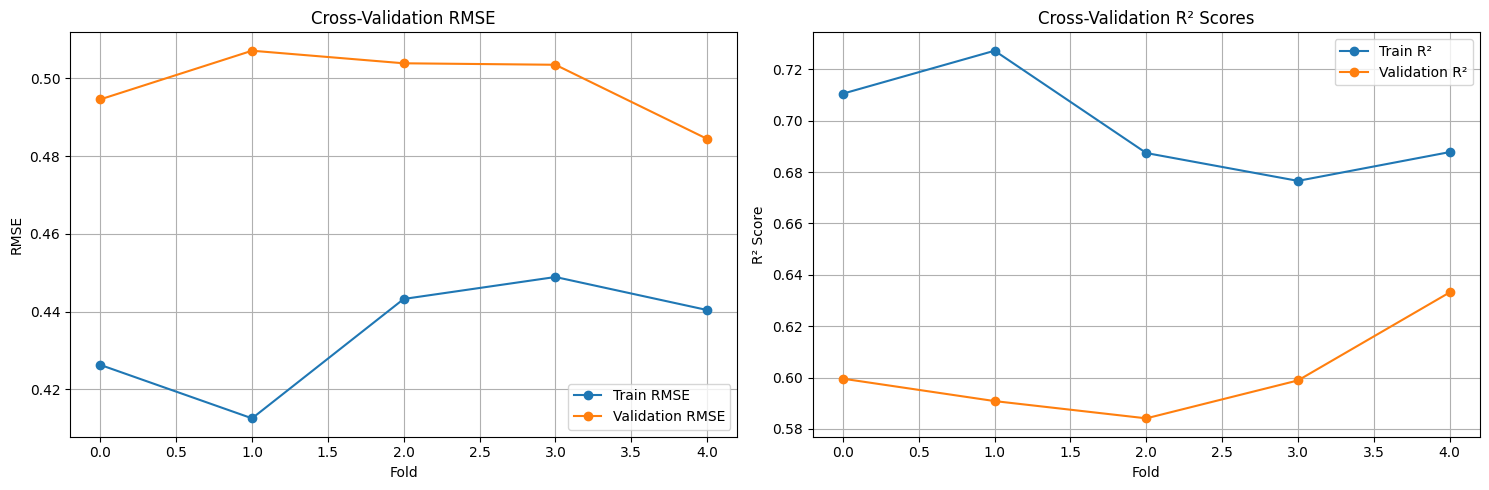


=== Cross-Validation Results ===
Average Train RMSE: 0.4343 (±0.0132)
Average Validation RMSE: 0.4987 (±0.0083)
Average Train R²: 0.6979 (±0.0184)
Average Validation R²: 0.6013 (±0.0169)

Training final model with 97 rounds...

Plotting learning curves...


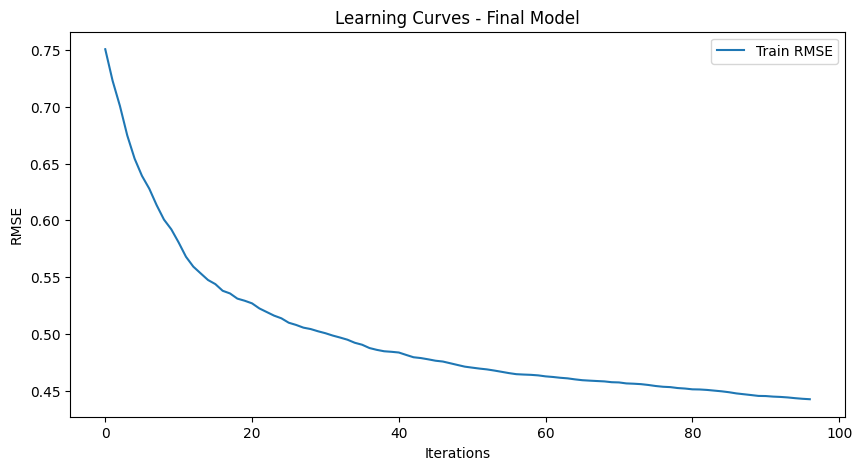


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.4231
R²: 0.6994
MAE: 0.2882

Plotting final model performance...


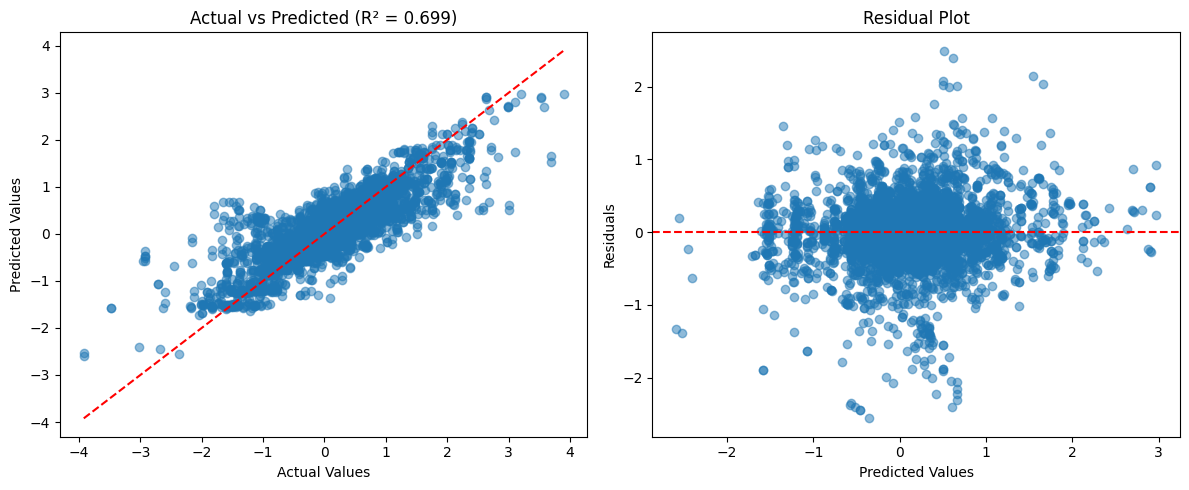


Saving results...
Done!

Plotting feature importance...


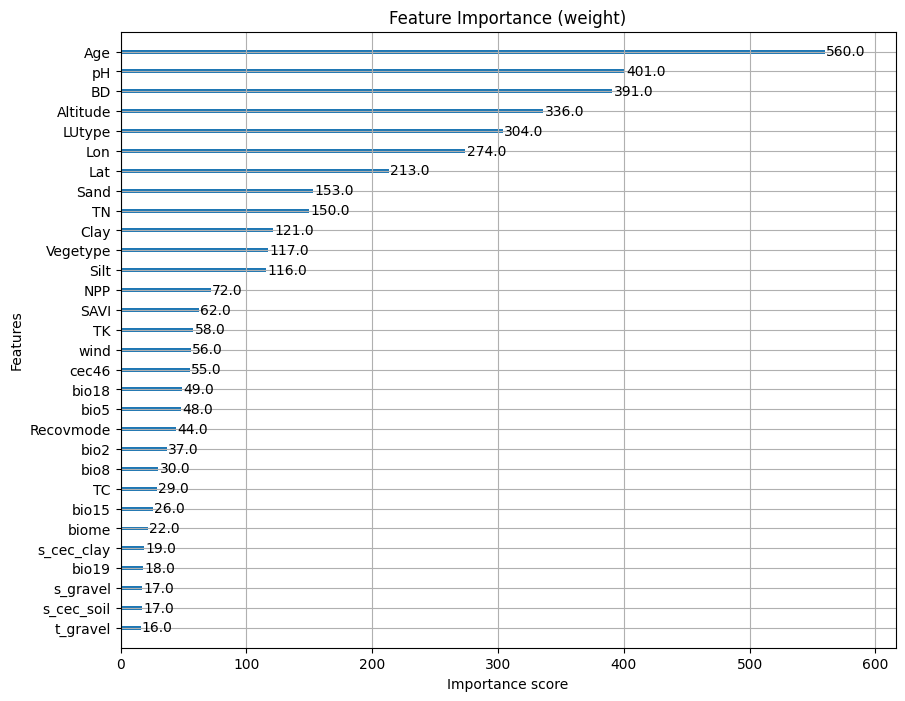

In [2]:
#all three models
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),#5,10
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
#   dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
#   final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-07 23:52:43,799] A new study created in memory with name: no-name-21671dc3-d3a3-4cfa-9e6e-c3b5f57c880d


7834
Starting optimized hyperparameter tuning...


[I 2025-09-07 23:52:51,377] Trial 4 finished with value: 0.5648743163958121 and parameters: {'eta': 0.018710413814724457, 'max_depth': 4, 'subsample': 0.5659213895029412, 'colsample_bytree': 0.6878756128034741, 'min_child_weight': 14, 'lambda': 7.664067712532857, 'alpha': 2.2427768338553977, 'gamma': 0.20230213836003413}. Best is trial 4 with value: 0.5648743163958121.
[I 2025-09-07 23:52:51,500] Trial 5 finished with value: 0.5368788576281796 and parameters: {'eta': 0.03834324669414696, 'max_depth': 4, 'subsample': 0.5981266745024759, 'colsample_bytree': 0.7446971893066054, 'min_child_weight': 10, 'lambda': 8.017223428188835, 'alpha': 5.6114503844650825, 'gamma': 0.2509355458629148}. Best is trial 5 with value: 0.5368788576281796.
[I 2025-09-07 23:52:51,570] Trial 6 finished with value: 0.544361783021066 and parameters: {'eta': 0.0441498090731342, 'max_depth': 4, 'subsample': 0.5694810007614394, 'colsample_bytree': 0.6990998209003885, 'min_child_weight': 12, 'lambda': 7.37162229391219


Running optimized cross-validation and saving CV models...

Saved CV models at:
- F:/model/results/cv_models\cv_model_fold_0.json
- F:/model/results/cv_models\cv_model_fold_1.json
- F:/model/results/cv_models\cv_model_fold_2.json
- F:/model/results/cv_models\cv_model_fold_3.json
- F:/model/results/cv_models\cv_model_fold_4.json

Plotting cross-validation results...


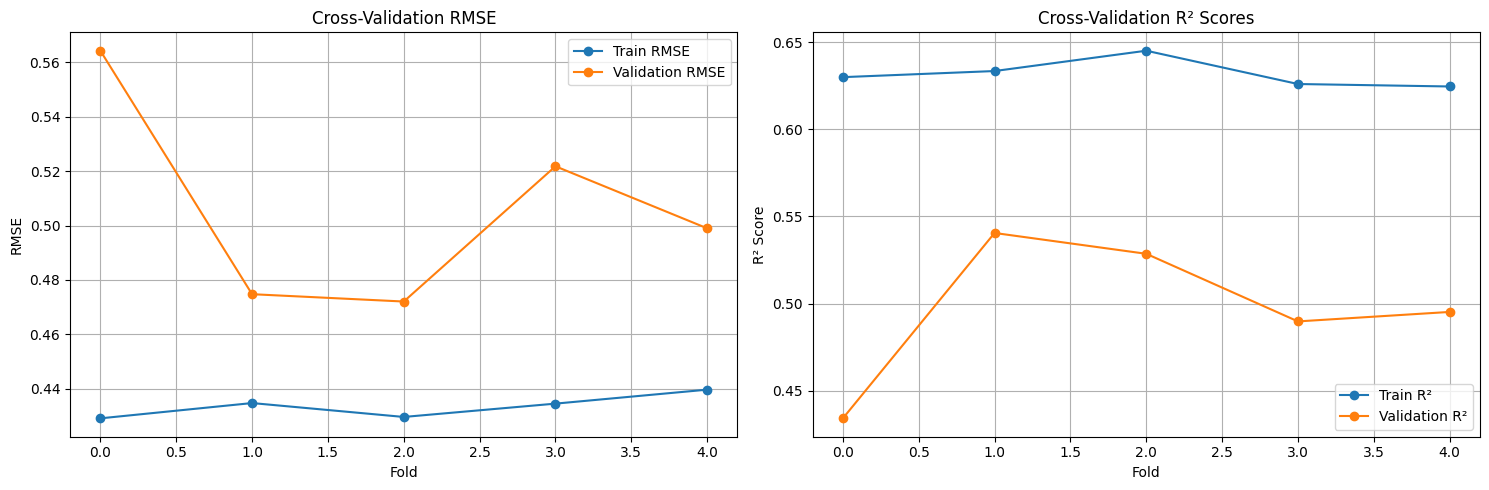


=== Cross-Validation Results ===
Average Train RMSE: 0.4336 (±0.0039)
Average Validation RMSE: 0.5064 (±0.0341)
Average Train R²: 0.6318 (±0.0073)
Average Validation R²: 0.4976 (±0.0371)

Training final model with 348 rounds...

Plotting learning curves...


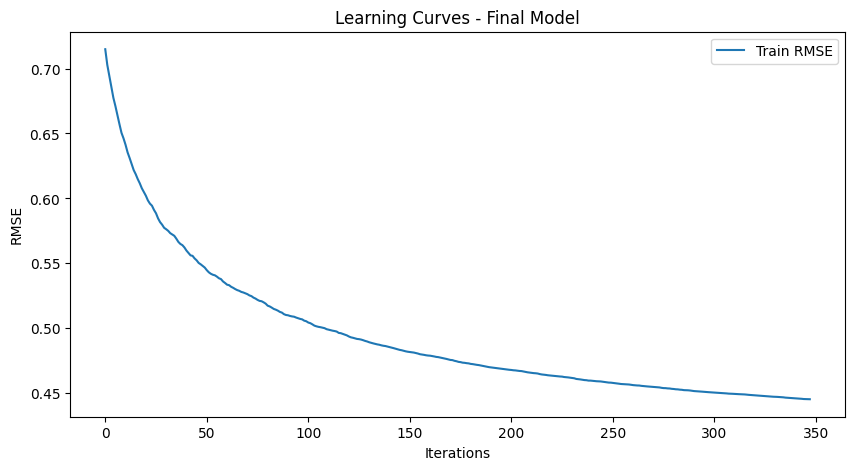


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.4698
R²: 0.6140
MAE: 0.3089

Plotting final model performance...


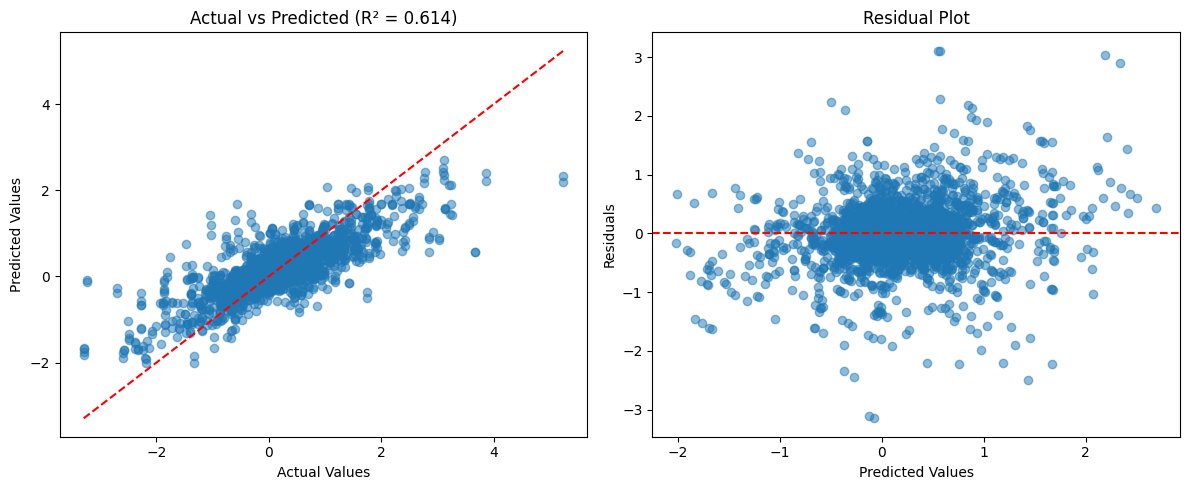


Saving results...
Done!

Plotting feature importance...


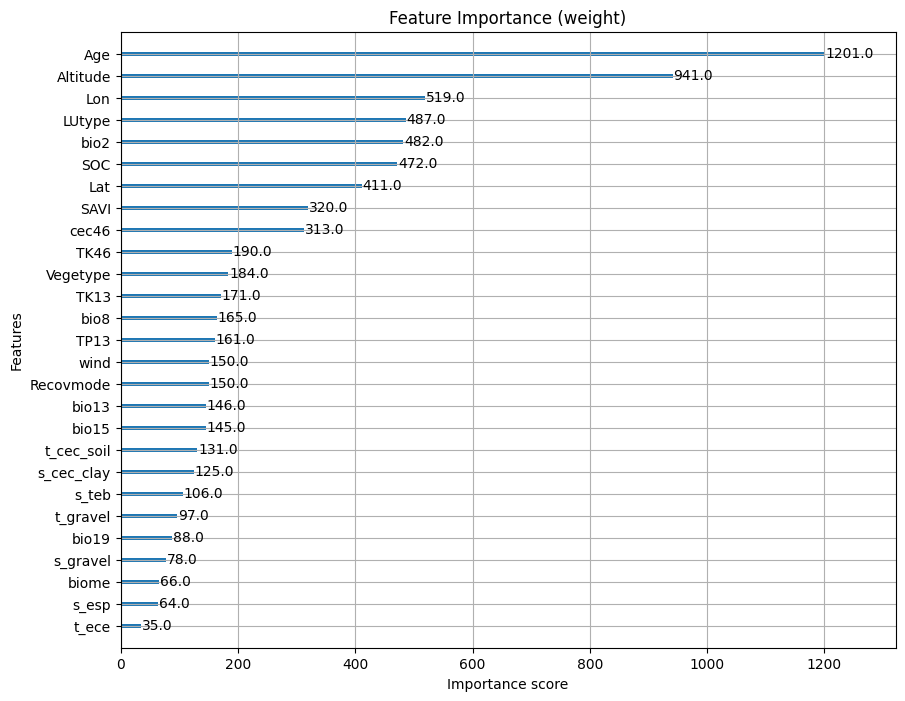

In [22]:
####old##LI modeling##################
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'lambda': trial.suggest_float('lambda', 5, 20.0),#5,10
            'alpha': trial.suggest_float('alpha', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
  #  dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
  #  final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)


    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Encoded categorical variable: LUtype with 7 classes
Encoded categorical variables: ['LUtype']


[I 2025-11-04 11:32:58,235] A new study created in memory with name: no-name-cb1c1773-8e06-42be-b2e2-af56bac931ce


Data augmentation completed: 1091 -> 4364 samples
Continuous variables enhanced: 6
Categorical variables enhanced: 1
Training set size: 3054
Testing set size: 1310
Total features: 32
Categorical features: ['LUtype']
Starting optimized hyperparameter tuning...


[I 2025-11-04 11:32:59,894] Trial 5 finished with value: 0.24074608729291871 and parameters: {'eta': 0.25527906653081206, 'max_depth': 5, 'subsample': 0.6499941393968619, 'colsample_bytree': 0.8175720387143525, 'min_child_weight': 7, 'lambda': 2.613693277405413, 'alpha': 1.6582115084262905, 'gamma': 0.0574360002215278}. Best is trial 5 with value: 0.24074608729291871.
[I 2025-11-04 11:33:02,092] Trial 3 finished with value: 0.2451604257490967 and parameters: {'eta': 0.17801738584468657, 'max_depth': 4, 'subsample': 0.6976534481828258, 'colsample_bytree': 0.82043352688329, 'min_child_weight': 5, 'lambda': 8.927388647685483, 'alpha': 1.9202129845710931, 'gamma': 0.008617971825655314}. Best is trial 5 with value: 0.24074608729291871.
[I 2025-11-04 11:33:02,594] Trial 7 finished with value: 0.26329122182078996 and parameters: {'eta': 0.16114915940080024, 'max_depth': 3, 'subsample': 0.670984584205946, 'colsample_bytree': 0.7342408537803777, 'min_child_weight': 4, 'lambda': 5.83640069949587


Running optimized cross-validation and saving CV models...

Training final model with 232 rounds...

Generating predictions for training and testing sets...

=== Prediction Results ===
Training set size: 3054
Testing set size: 1310

Training Set:
RMSE: 0.2022
R²: 0.8504
Correlation: 0.9254
Actual mean: 0.1548, Predicted mean: 0.1515

Testing Set:
RMSE: 0.2001
R²: 0.8547
Correlation: 0.9280
Actual mean: 0.1162, Predicted mean: 0.1218

Saving prediction results to CSV...
Prediction results saved to:
- F:/model/results/training_set_predictions.csv
- F:/model/results/testing_set_predictions.csv
- F:/model/results/all_predictions.csv

Plotting prediction correlations...


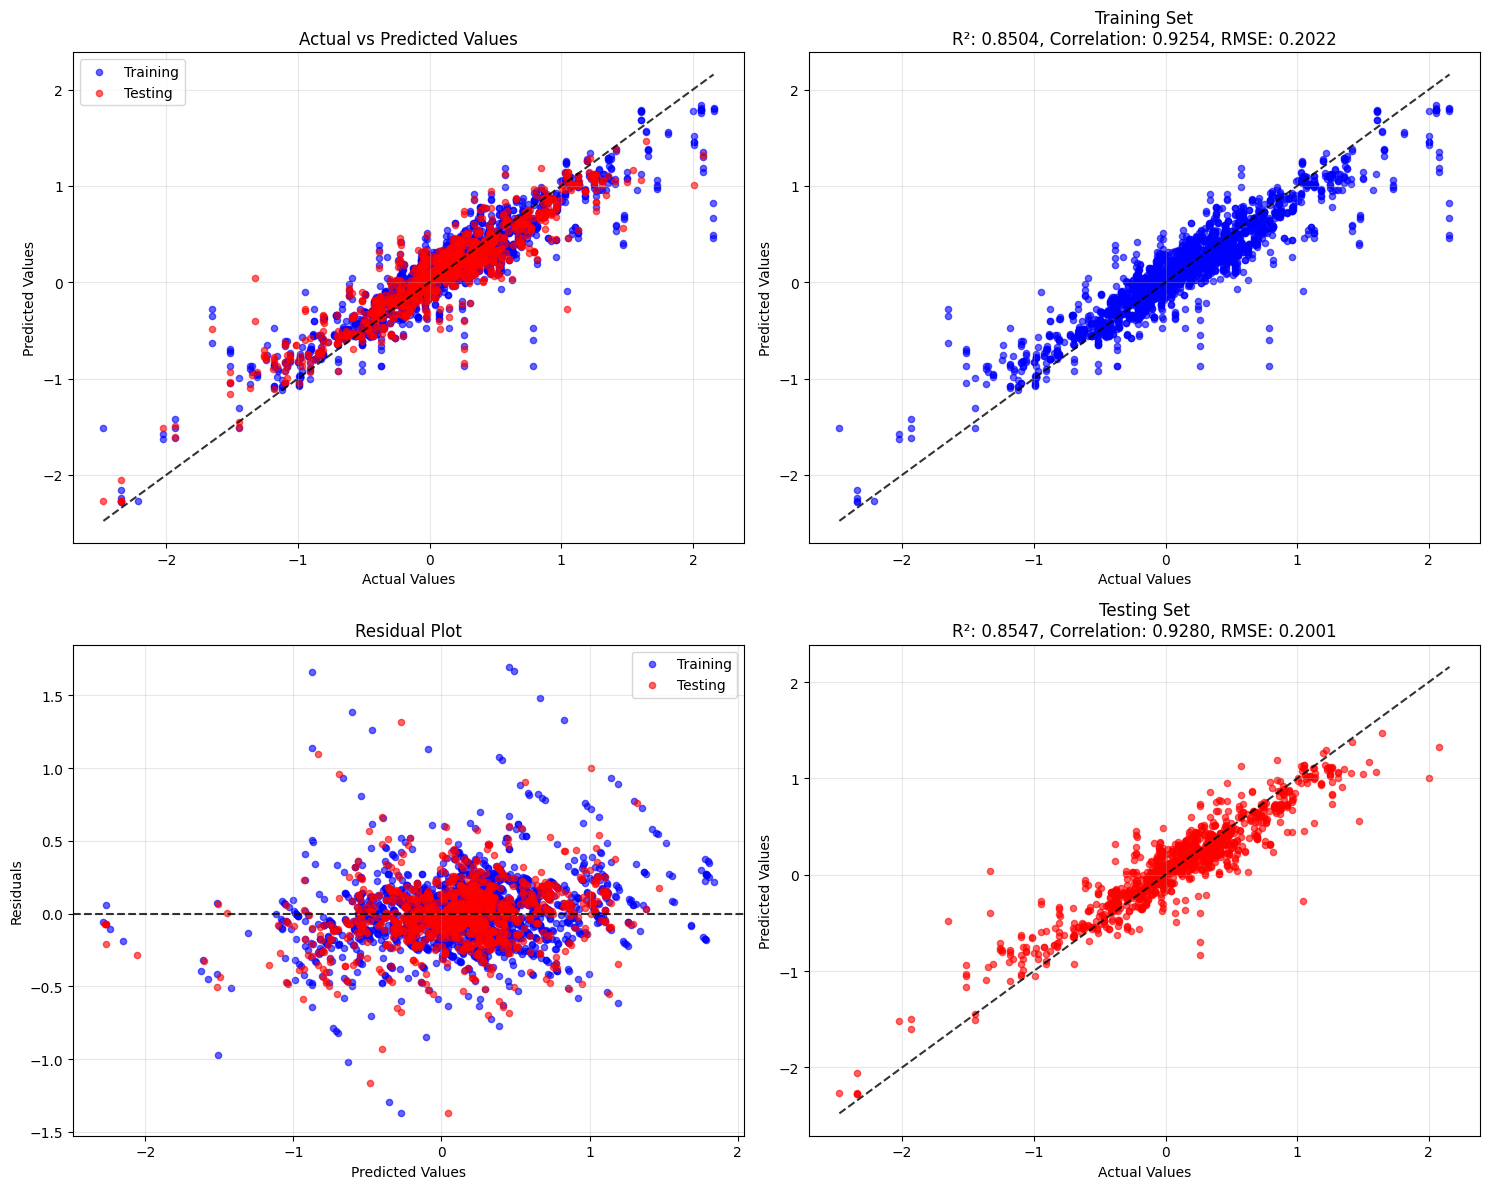


Plotting learning curves...


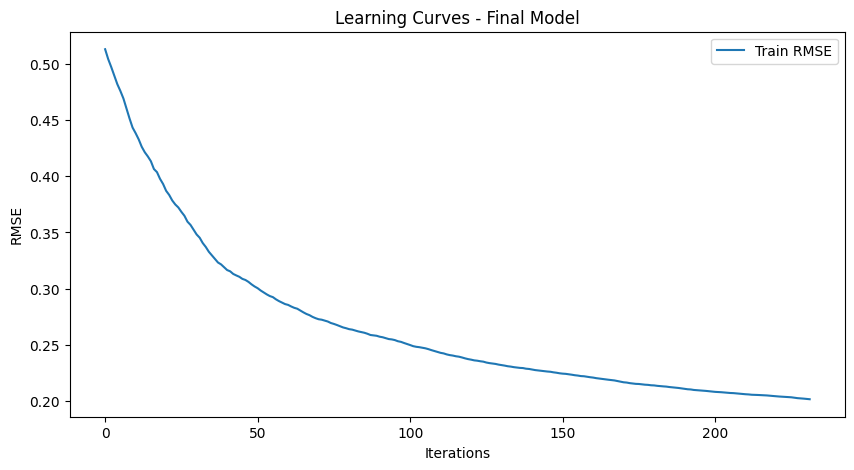


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.2001
R²: 0.8547
MAE: 0.1363

Plotting final model performance...


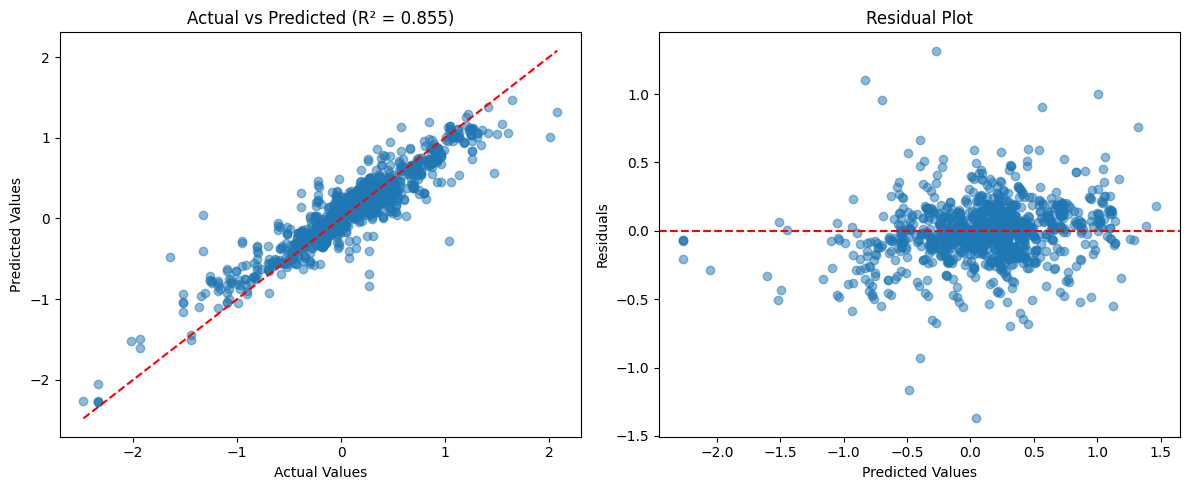


Plotting feature importance...


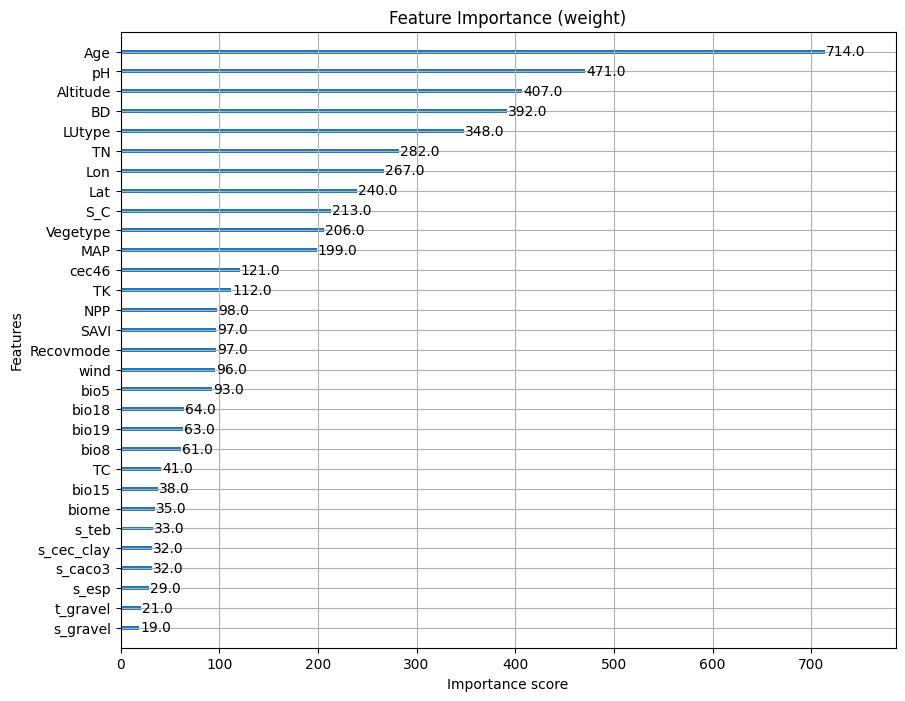


Saving results...

Done!


In [8]:
# SOC model
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None
        self.label_encoders = {}  # 存储标签编码器

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax, max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        model.save_model(f'{output_dir}/xgb_model.json')

        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

    def get_predictions(self, model, X_train, X_test, y_train, y_test):
        """获取训练集和测试集的预测值"""
        # 创建DMatrix对象用于预测
        dtrain_pred = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
        dtest_pred = xgb.DMatrix(X_test, feature_names=X_train.columns.tolist())
        
        # 训练集预测
        train_pred = model.predict(dtrain_pred)
        
        # 测试集预测
        test_pred = model.predict(dtest_pred)
        
        # 创建包含预测值的数据框
        train_results = pd.DataFrame({
            'Actual': y_train.values,
            'Predicted': train_pred,
            'Set': 'Training'
        })
        
        test_results = pd.DataFrame({
            'Actual': y_test.values,
            'Predicted': test_pred,
            'Set': 'Testing'
        })
        
        # 合并结果
        all_results = pd.concat([train_results, test_results], ignore_index=True)
        
        return all_results, train_pred, test_pred
    
    def plot_predictions_correlation(self, all_results):
        """绘制预测值和实际值的相关性图"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. 训练集和测试集的散点图
        sets = ['Training', 'Testing']
        colors = ['blue', 'red']
        
        for i, set_type in enumerate(sets):
            set_data = all_results[all_results['Set'] == set_type]
            axes[0, 0].scatter(set_data['Actual'], set_data['Predicted'], 
                              alpha=0.6, color=colors[i], label=set_type, s=20)
        
        # 添加理想线
        min_val = all_results['Actual'].min()
        max_val = all_results['Actual'].max()
        axes[0, 0].plot([min_val, max_val], [min_val, max_val], '--', color='black', alpha=0.8)
        axes[0, 0].set_xlabel('Actual Values')
        axes[0, 0].set_ylabel('Predicted Values')
        axes[0, 0].set_title('Actual vs Predicted Values')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. 分别显示训练集和测试集的相关性
        for i, set_type in enumerate(sets):
            set_data = all_results[all_results['Set'] == set_type]
            correlation = set_data['Actual'].corr(set_data['Predicted'])
            r2 = r2_score(set_data['Actual'], set_data['Predicted'])
            rmse = np.sqrt(mean_squared_error(set_data['Actual'], set_data['Predicted']))
            
            row = i
            col = 1
            
            axes[row, col].scatter(set_data['Actual'], set_data['Predicted'], 
                                 alpha=0.6, color=colors[i], s=20)
            axes[row, col].plot([min_val, max_val], [min_val, max_val], '--', color='black', alpha=0.8)
            axes[row, col].set_xlabel('Actual Values')
            axes[row, col].set_ylabel('Predicted Values')
            axes[row, col].set_title(f'{set_type} Set\nR²: {r2:.4f}, Correlation: {correlation:.4f}, RMSE: {rmse:.4f}')
            axes[row, col].grid(True, alpha=0.3)
        
        # 3. 残差图
        for i, set_type in enumerate(sets):
            set_data = all_results[all_results['Set'] == set_type]
            residuals = set_data['Actual'] - set_data['Predicted']
            
            axes[1, 0].scatter(set_data['Predicted'], residuals, 
                              alpha=0.6, color=colors[i], label=set_type, s=20)
        
        axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.8)
        axes[1, 0].set_xlabel('Predicted Values')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residual Plot')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig

def encode_categorical_features(X, categorical_cols):
    """对分类变量进行标签编码"""
    label_encoders = {}
    X_encoded = X.copy()
    
    for col in categorical_cols:
        if col in X_encoded.columns:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            label_encoders[col] = le
            print(f"Encoded categorical variable: {col} with {len(le.classes_)} classes")
    
    return X_encoded, label_encoders

def augment_features(X, y, continuous_cols, categorical_cols, augmentation_factor=2, 
                    continuous_noise_scale=0.01, categorical_mix_prob=0.1, random_state=42):
    """
    增强连续变量和分类变量的函数
    
    参数:
    - X: 特征数据
    - y: 目标变量
    - continuous_cols: 连续变量列名列表
    - categorical_cols: 分类变量列名列表
    - augmentation_factor: 增强倍数
    - continuous_noise_scale: 连续变量噪声比例
    - categorical_mix_prob: 分类变量混合概率
    - random_state: 随机种子
    """
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        # 随机选择基础样本
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        # 增强连续变量
        for col in continuous_cols:
            if col in base_sample.index:
                std = X[col].std()
                noise = np.random.normal(loc=0, scale=std * continuous_noise_scale)
                if X[col].min() >= 0:
                    base_sample[col] = max(0, base_sample[col] + noise)
                else:
                    base_sample[col] += noise

        # 增强分类变量 - 使用混合方法
        for col in categorical_cols:
            if col in base_sample.index:
                # 有一定概率从其他样本中随机选择分类值
                if np.random.random() < categorical_mix_prob:
                    other_idx = np.random.randint(0, n_samples)
                    base_sample[col] = X.iloc[other_idx][col]

        # 添加到增强数据集
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    print(f"Data augmentation completed: {n_samples} -> {len(X_augmented)} samples")
    print(f"Continuous variables enhanced: {len(continuous_cols)}")
    print(f"Categorical variables enhanced: {len(categorical_cols)}")
    
    return X_augmented, y_augmented

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with enhanced data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    
    # 添加变换特征
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可根据需要修改为'topsoil'
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
    
    # 识别分类变量（假设包含LUtype）
    categorical_cols = ['LUtype']  # 添加其他分类变量
    categorical_cols = [col for col in categorical_cols if col in x1.columns]
    
    # 对分类变量进行编码
    if categorical_cols:
        x1, label_encoders = encode_categorical_features(x1, categorical_cols)
        print(f"Encoded categorical variables: {categorical_cols}")
   
    if augment:
        # 定义连续变量
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]

        # 使用增强的数据增强函数
        x1, y1 = augment_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            categorical_cols=categorical_cols,
            augmentation_factor=augmentation_factor,
            continuous_noise_scale=0.01,
            categorical_mix_prob=0.1,
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")
    print(f"Total features: {len(X_train.columns)}")
    if categorical_cols:
        print(f"Categorical features: {categorical_cols}")

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # 4. 获取预测值
    print("\nGenerating predictions for training and testing sets...")
    all_results, train_pred, test_pred = tuner.get_predictions(
        final_model, X_train, X_test, y_train, y_test
    )
    
    # 5. 输出预测值统计信息
    print("\n=== Prediction Results ===")
    print(f"Training set size: {len(train_pred)}")
    print(f"Testing set size: {len(test_pred)}")
    
    # 训练集统计
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r2 = r2_score(y_train, train_pred)
    train_corr = np.corrcoef(y_train, train_pred)[0, 1]
    
    print(f"\nTraining Set:")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"R²: {train_r2:.4f}")
    print(f"Correlation: {train_corr:.4f}")
    print(f"Actual mean: {y_train.mean():.4f}, Predicted mean: {train_pred.mean():.4f}")
    
    # 测试集统计
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)
    test_corr = np.corrcoef(y_test, test_pred)[0, 1]
    
    print(f"\nTesting Set:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"R²: {test_r2:.4f}")
    print(f"Correlation: {test_corr:.4f}")
    print(f"Actual mean: {y_test.mean():.4f}, Predicted mean: {test_pred.mean():.4f}")
    
    # 6. 保存预测结果到CSV文件
    print("\nSaving prediction results to CSV...")
    
    # 创建详细的结果数据框
    train_results_df = pd.DataFrame({
        'Actual': y_train.values,
        'Predicted': train_pred,
        'Residual': y_train.values - train_pred
    })
    
    test_results_df = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': test_pred,
        'Residual': y_test.values - test_pred
    })
    
    # 保存到文件
    train_results_df.to_csv('F:/model/results/training_set_predictions.csv', index=False)
    test_results_df.to_csv('F:/model/results/testing_set_predictions.csv', index=False)
    all_results.to_csv('F:/model/results/all_predictions.csv', index=False)
    
    print("Prediction results saved to:")
    print("- F:/model/results/training_set_predictions.csv")
    print("- F:/model/results/testing_set_predictions.csv")
    print("- F:/model/results/all_predictions.csv")
    
    # 7. 绘制相关性图
    print("\nPlotting prediction correlations...")
    tuner.plot_predictions_correlation(all_results)
    
    # 8. 原有的评估和绘图代码
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
    
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    print("\nDone!")

if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-07 23:41:34,722] A new study created in memory with name: no-name-5ea4dbc2-3fc9-4e61-a9d6-51361a5b8b62


4149
Starting optimized hyperparameter tuning...


[I 2025-09-07 23:41:38,114] Trial 0 finished with value: 0.46795477023373255 and parameters: {'eta': 0.11419298392352063, 'max_depth': 7, 'subsample': 0.6922581052184017, 'colsample_bytree': 0.96316143485438, 'colsample_bylevel': 0.8843706319293734, 'colsample_bynode': 0.5656690867912351, 'min_child_weight': 2, 'lambda': 0.009452599509910611, 'alpha': 0.11199396925901206, 'gamma': 0.1689222129218826, 'max_delta_step': 4}. Best is trial 0 with value: 0.46795477023373255.
[I 2025-09-07 23:41:38,632] Trial 1 finished with value: 0.49589708664427395 and parameters: {'eta': 0.1395688437551348, 'max_depth': 8, 'subsample': 0.721630195687094, 'colsample_bytree': 0.6752588289973019, 'colsample_bylevel': 0.9096321790479056, 'colsample_bynode': 0.747626149450406, 'min_child_weight': 2, 'lambda': 4.550504931336302, 'alpha': 1.2869515763634838, 'gamma': 3.3385031633255884, 'max_delta_step': 1}. Best is trial 0 with value: 0.46795477023373255.
[I 2025-09-07 23:41:39,001] Trial 3 finished with value


Running optimized cross-validation and saving CV models...

Saved CV models at:
- F:/model/results/cv_models\cv_model_fold_0.json
- F:/model/results/cv_models\cv_model_fold_1.json
- F:/model/results/cv_models\cv_model_fold_2.json
- F:/model/results/cv_models\cv_model_fold_3.json
- F:/model/results/cv_models\cv_model_fold_4.json

Plotting cross-validation results...


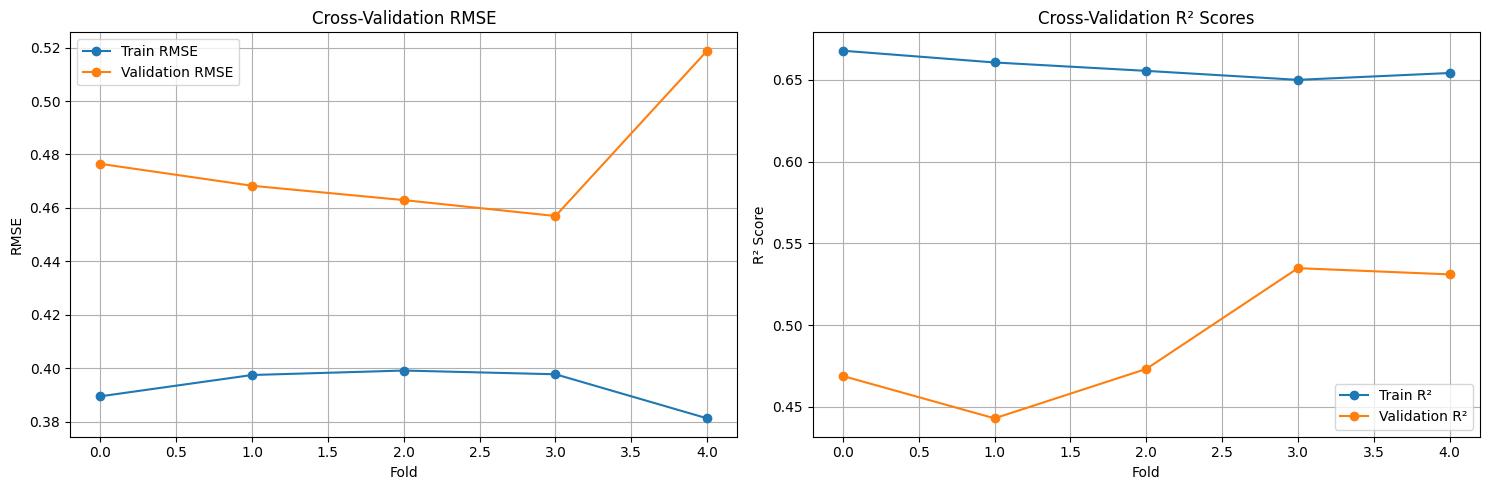


=== Cross-Validation Results ===
Average Train RMSE: 0.3930 (±0.0068)
Average Validation RMSE: 0.4767 (±0.0220)
Average Train R²: 0.6577 (±0.0061)
Average Validation R²: 0.4902 (±0.0364)

Training final model with 70 rounds...

Plotting learning curves...


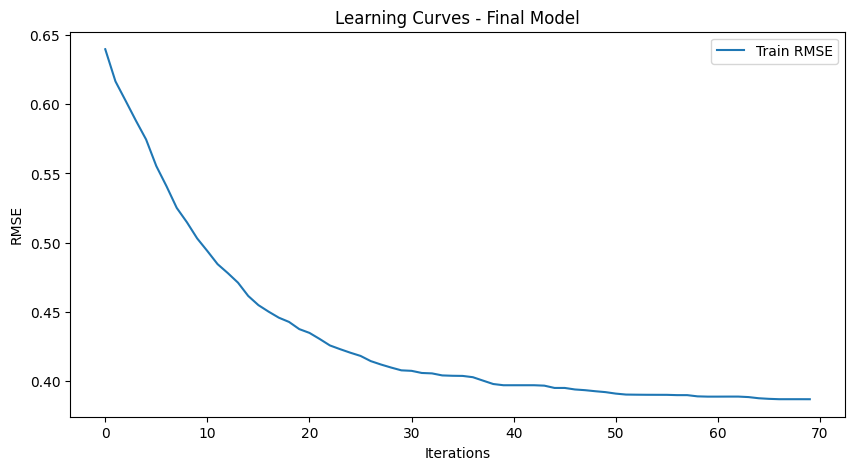


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.3731
R²: 0.6655
MAE: 0.2673

Plotting final model performance...


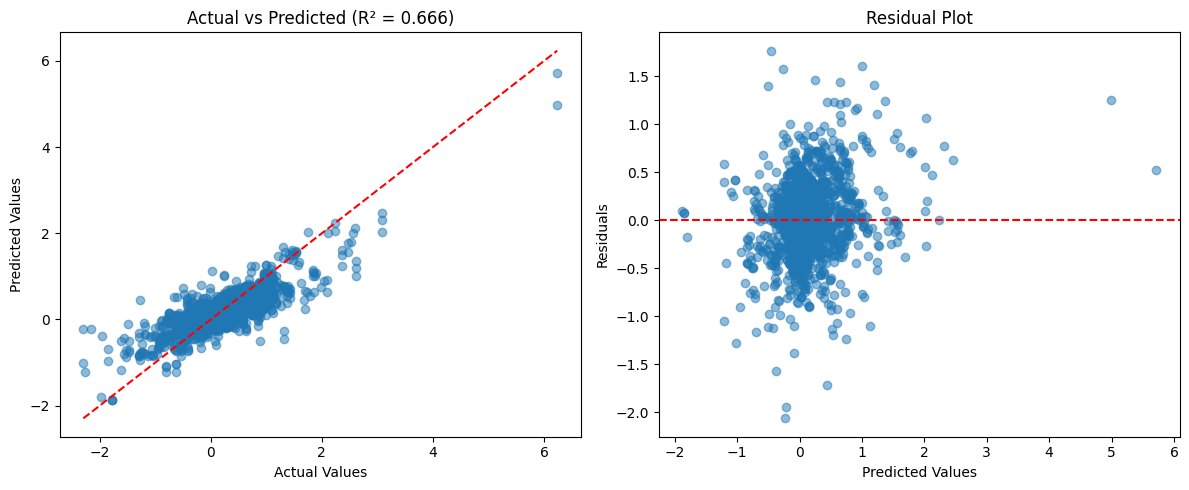


Saving results...
Done!

Plotting feature importance...


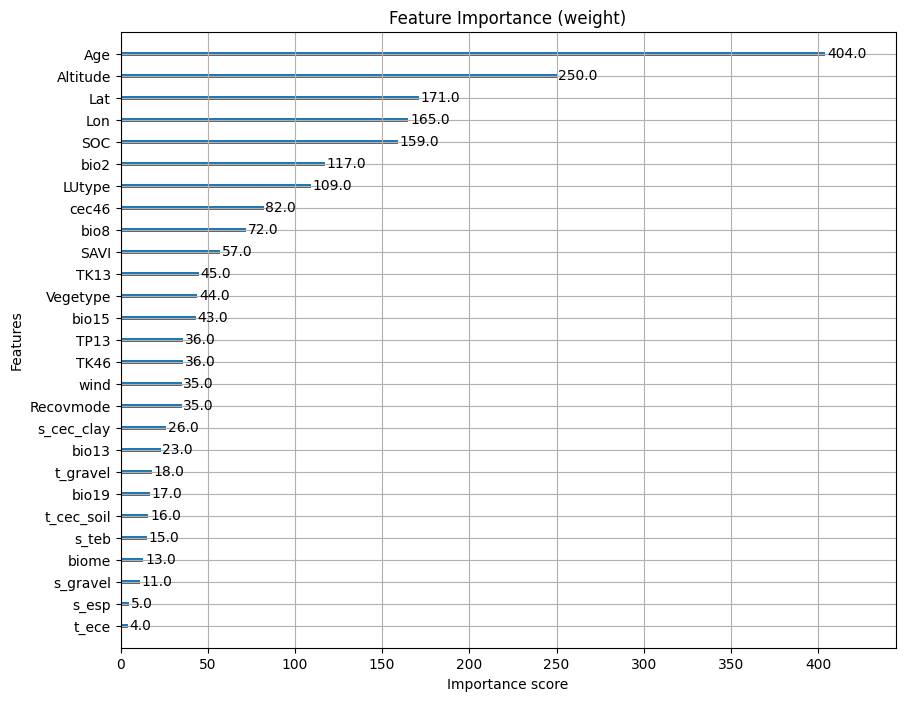

In [ ]:
#####new#LI modeling##################
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.005, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 0, 5.0),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),
            'objective': 'reg:absoluteerror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
  #  dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
  #  final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)


    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

In [9]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import re
import os
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else os.cpu_count()
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None
        self.scaler = None

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def create_preprocessing_pipeline(self, X):
        """Create preprocessing pipeline for different feature types"""
        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features)
            ],
            remainder='passthrough'
        )
        
        return preprocessor

    def objective(self, trial, X, y, n_splits=5):
        """Enhanced objective function with proper cross-validation"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'random_state': self.seed,
            'n_jobs': 1
        }

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Preprocess data
            if self.scaler is None:
                self.scaler = self.create_preprocessing_pipeline(X_train)
                X_train = self.scaler.fit_transform(X_train)
                X_val = self.scaler.transform(X_val)
            else:
                X_train = self.scaler.transform(X_train)
                X_val = self.scaler.transform(X_val)

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            model = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=1000,
                evals=[(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=50,
                verbose_eval=False
            )

            val_pred = model.predict(dval)
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            rmse_scores.append(rmse)

        return np.mean(rmse_scores)

    def tune_hyperparameters(self, X, y, n_trials=100, n_splits=5):
        """Parallelized hyperparameter tuning with proper study setup"""
        study = optuna.create_study(
            direction='minimize',
            sampler=optuna.samplers.TPESampler(seed=self.seed),
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
        )

        study.optimize(
            lambda trial: self.objective(trial, X, y, n_splits),
            n_trials=n_trials,
            n_jobs=min(self.n_jobs, n_trials),
            show_progress_bar=True
        )

        self.study = study
        self.best_params = study.best_params.copy()
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'random_state': self.seed,
            'n_jobs': self.n_jobs
        })

        return self.best_params

    def train_model(self, X_train, y_train, X_val=None, y_val=None, num_boost_round=1000):
        """Optimized training with early stopping"""
        # Preprocess data
        if self.scaler is None:
            self.scaler = self.create_preprocessing_pipeline(X_train)
            X_train_scaled = self.scaler.fit_transform(X_train)
            if X_val is not None:
                X_val_scaled = self.scaler.transform(X_val)
        else:
            X_train_scaled = self.scaler.transform(X_train)
            if X_val is not None:
                X_val_scaled = self.scaler.transform(X_val)

        dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=X_train.columns.tolist())
        
        evals = [(dtrain, 'train')]
        if X_val is not None:
            dval = xgb.DMatrix(X_val_scaled, label=y_val, feature_names=X_train.columns.tolist())
            evals.append((dval, 'val'))

        evals_result = {}
        model = xgb.train(
            params=self.best_params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=100,
            evals_result=evals_result
        )

        self.feature_names = X_train.columns.tolist()
        return model, evals_result

    def cross_validate(self, X, y, n_splits=5, n_repeats=3, cv_models_dir='./cv_models'):
        """Enhanced CV with repeated k-fold and proper parallelization"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)
        
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'repeat': [], 'fold': []
        }

        rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=self.seed)

        def process_fold(repeat_idx, fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Preprocess for this fold
            scaler = self.create_preprocessing_pipeline(X_train)
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
            dval = xgb.DMatrix(X_val_scaled, label=y_val)

            model = xgb.train(
                params=self.best_params,
                dtrain=dtrain,
                num_boost_round=1000,
                evals=[(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=50,
                verbose_eval=False
            )

            model_path = os.path.join(cv_models_dir, f'cv_model_repeat_{repeat_idx}_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration,
                model_path,
                repeat_idx,
                fold_idx % n_splits
            )

        with ThreadPoolExecutor(max_workers=min(self.n_jobs, n_splits * n_repeats)) as executor:
            futures = []
            for repeat_idx, (train_idx, val_idx) in enumerate(rkf.split(X)):
                fold_idx = repeat_idx
                futures.append(executor.submit(process_fold, repeat_idx // n_splits, fold_idx, train_idx, val_idx))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, repeat_idx, fold_idx = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['repeat'].append(repeat_idx)
                cv_results['fold'].append(fold_idx)

        return cv_results

    def evaluate_model(self, model, X_test, y_test):
        """Evaluate model performance on test set"""
        X_test_scaled = self.scaler.transform(X_test)
        dtest = xgb.DMatrix(X_test_scaled, label=y_test)
        test_pred = model.predict(dtest)
        
        return {
            'rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
            'r2': r2_score(y_test, test_pred),
            'mae': mean_absolute_error(y_test, test_pred),
            'mape': np.mean(np.abs((y_test - test_pred) / y_test)) * 100
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        if 'train' in evals_result and 'rmse' in evals_result['train']:
            train_rmse = evals_result['train']['rmse']
            plt.plot(range(len(train_rmse)), train_rmse, label='Train RMSE')
        if 'val' in evals_result and 'rmse' in evals_result['val']:
            val_rmse = evals_result['val']['rmse']
            plt.plot(range(len(val_rmse)), val_rmse, label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        
        plt.subplot(1, 2, 2)
        if 'train' in evals_result and 'rmse' in evals_result['train']:
            plt.semilogy(range(len(train_rmse)), train_rmse, label='Train RMSE (log)')
        if 'val' in evals_result and 'rmse' in evals_result['val']:
            plt.semilogy(range(len(val_rmse)), val_rmse, label='Validation RMSE (log)')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE (log scale)')
        
        plt.tight_layout()
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # RMSE plots
        axes[0, 0].plot(cv_results['train_rmse'], 'o-', alpha=0.7, label='Train RMSE')
        axes[0, 0].plot(cv_results['val_rmse'], 'o-', alpha=0.7, label='Validation RMSE')
        axes[0, 0].set_xlabel('Fold')
        axes[0, 0].set_ylabel('RMSE')
        axes[0, 0].set_title('Cross-Validation RMSE')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # R² plots
        axes[0, 1].plot(cv_results['train_r2'], 'o-', alpha=0.7, label='Train R²')
        axes[0, 1].plot(cv_results['val_r2'], 'o-', alpha=0.7, label='Validation R²')
        axes[0, 1].set_xlabel('Fold')
        axes[0, 1].set_ylabel('R² Score')
        axes[0, 1].set_title('Cross-Validation R² Scores')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Box plots
        axes[1, 0].boxplot([cv_results['train_rmse'], cv_results['val_rmse']], 
                          labels=['Train RMSE', 'Validation RMSE'])
        axes[1, 0].set_title('RMSE Distribution')
        
        axes[1, 1].boxplot([cv_results['train_r2'], cv_results['val_r2']], 
                          labels=['Train R²', 'Validation R²'])
        axes[1, 1].set_title('R² Distribution')
        
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=20):
        """Plot feature importance with better visualization"""
        importance_scores = model.get_score(importance_type=importance_type)
        if not importance_scores:
            importance_scores = model.get_score(importance_type='gain')
        
        features = list(importance_scores.keys())
        scores = list(importance_scores.values())
        
        # Sort by importance
        sorted_idx = np.argsort(scores)[-top_n:]
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(sorted_idx)), [scores[i] for i in sorted_idx])
        plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
        plt.xlabel('Importance Score')
        plt.title(f'Feature Importance ({importance_type})')
        plt.tight_layout()
        plt.show()

    def save_results(self, model, output_dir='./results'):
        """Save all results to disk"""
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        model.save_model(f'{output_dir}/xgb_model.json')
        
        if self.feature_names:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))
        
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')
        joblib.dump(self.scaler, f'{output_dir}/scaler.pkl')
        
        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function"""
    # Your existing data loading code here
    # Keep your current implementation
    pass

def main():
    # Load data
    X, y, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # Hyperparameter tuning
    print("Starting hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(X_train, y_train, n_trials=100)
    
    print(f"\nBest parameters: {best_params}")

    # Cross-validation
    print("\nRunning repeated cross-validation...")
    cv_results = tuner.cross_validate(
        X_train, y_train,
        n_splits=5, n_repeats=3,
        cv_models_dir='F:/model/results/cv_models'
    )

    # Analyze CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(X_train, y_train, num_boost_round=optimal_rounds)

    # Evaluate final model
    test_metrics, test_pred = tuner.evaluate_model(final_model, X_test, y_test)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"MAPE: {test_metrics['mape']:.2f}%")

    # Plot results
    tuner.plot_learning_curves(evals_result, "Final Model")
    tuner.plot_cv_results(cv_results)
    tuner.plot_feature_importance(final_model)

    # Save results
    tuner.save_results(final_model, output_dir='F:/model/results')
    print("Done!")

if __name__ == "__main__":
    main()

TypeError: cannot unpack non-iterable NoneType object

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-05 14:51:49,040] A new study created in memory with name: no-name-ff158797-5e97-460c-af35-585af1c6b78e


3054
Starting optimized hyperparameter tuning...


[I 2025-09-05 14:51:51,045] Trial 2 finished with value: 0.2505185708371297 and parameters: {'eta': 0.1732055278130842, 'max_depth': 6, 'subsample': 0.6674576374876928, 'colsample_bytree': 0.8756673432921627, 'min_child_weight': 5, 'lambda': 5.620246840604228, 'alpha': 0.5826137190299792, 'gamma': 0.18457459100985574}. Best is trial 2 with value: 0.2505185708371297.
[I 2025-09-05 14:51:52,932] Trial 7 finished with value: 0.25947662779620295 and parameters: {'eta': 0.09339692321031604, 'max_depth': 4, 'subsample': 0.6904252563640099, 'colsample_bytree': 0.8360521584881944, 'min_child_weight': 4, 'lambda': 9.82875471801471, 'alpha': 1.3895839530675187, 'gamma': 0.1353758239595933}. Best is trial 2 with value: 0.2505185708371297.
[I 2025-09-05 14:51:53,888] Trial 3 finished with value: 0.24335954520285102 and parameters: {'eta': 0.06281229028025224, 'max_depth': 5, 'subsample': 0.7993257815072432, 'colsample_bytree': 0.8923117104337579, 'min_child_weight': 4, 'lambda': 2.001335928809792,


Running optimized cross-validation and saving CV models...

=== Final Test Metrics (unbiased) ===
RMSE: 0.2314
R²: 0.8111
MAE: 0.1491

Plotting cross-validation results...


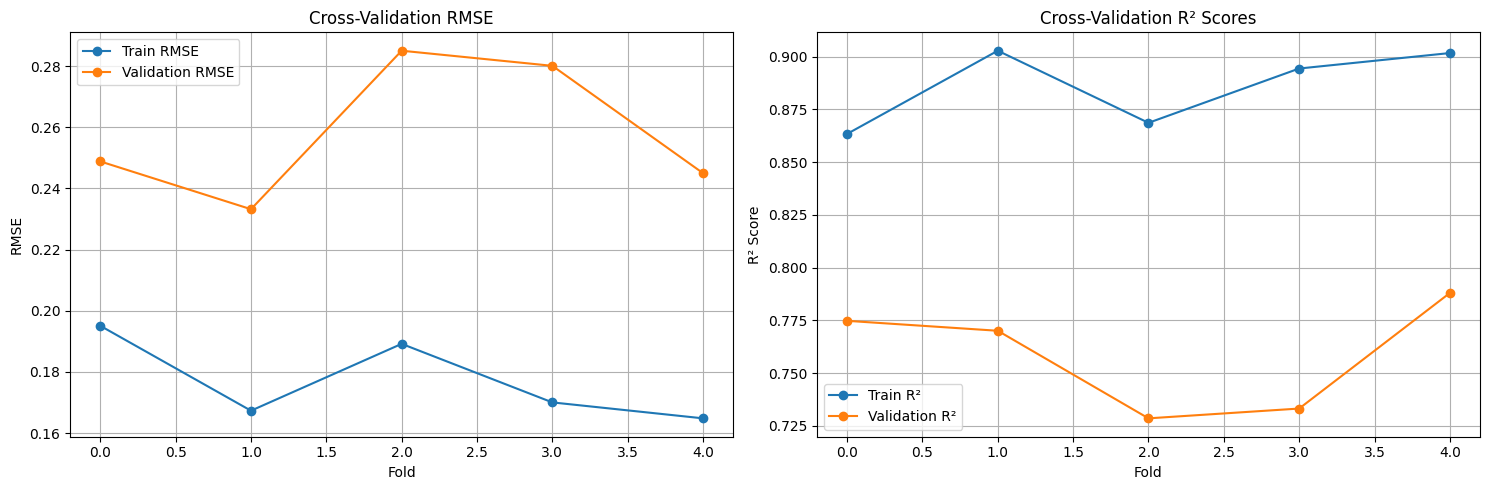


Training final mapping model with 291 rounds on ALL data...

Saving results...
Done!

Plotting feature importance...


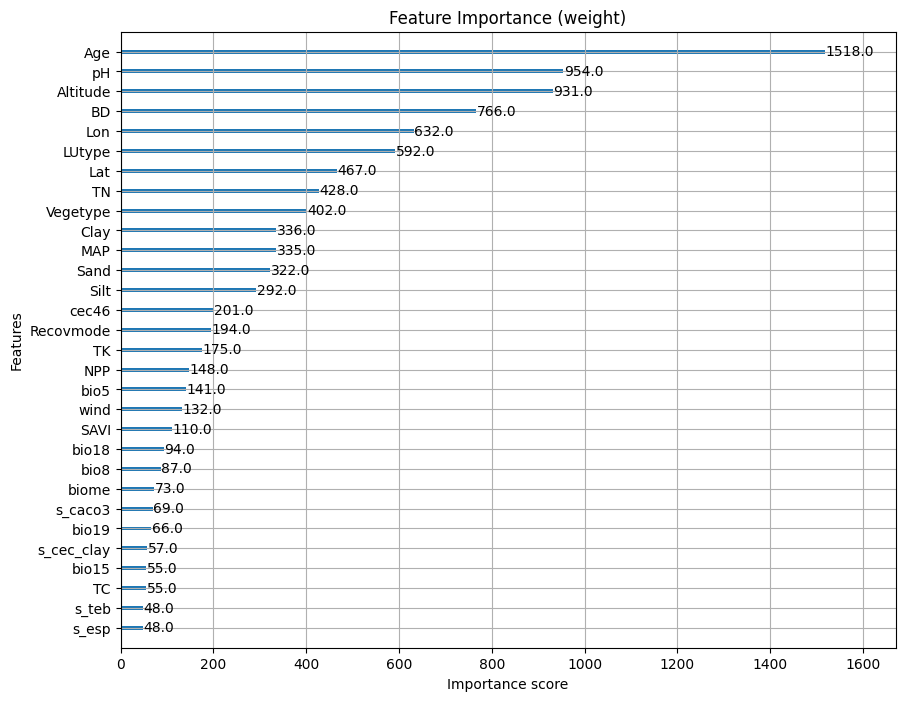

In [68]:
#Mapping models
#all three models
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),#5,10
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models'
    )

    # ✅ Unbiased test evaluation (train-only model on train set, evaluate on held-out test)
    dtrain_final = xgb.DMatrix(
        X_train, label=y_train, feature_names=X_train.columns.tolist()
    )
    temp_model, _ = tuner.train_model(
        best_params, dtrain_final,
        num_boost_round=int(np.mean(cv_results['best_iterations']))
    )
    test_metrics, _ = tuner.evaluate_model(temp_model, dtest)
    print("\n=== Final Test Metrics (unbiased) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # 3. Train final model on ALL data (mapping model, no test eval here 🚨)
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final mapping model with {optimal_rounds} rounds on ALL data...")
    dtrain_all = xgb.DMatrix(
        x1, label=y1, feature_names=x1.columns.tolist()
    )
    final_model, evals_result = tuner.train_model(
        best_params, dtrain_all,
        num_boost_round=optimal_rounds
    )

    # 🚫 不再做 dtest 评估（避免数据泄漏）
    # ✅ 保存 + 特征重要性 + SHAP
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")

    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)

    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)  # 用 X_test 只是展示 shap，可保留

if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-09-05 15:06:30,900] A new study created in memory with name: no-name-9ed8056d-7be8-4f0c-8896-606eb5febfa6


7772
Starting optimized hyperparameter tuning...


[I 2025-09-05 15:06:36,769] Trial 6 finished with value: 0.6191476352342101 and parameters: {'eta': 0.01755472989437671, 'max_depth': 3, 'subsample': 0.6855210670577458, 'colsample_bytree': 0.6191325846798627, 'min_child_weight': 12, 'lambda': 15.693607741141378, 'alpha': 4.280335714237964, 'gamma': 0.17353376971960652}. Best is trial 6 with value: 0.6191476352342101.
[I 2025-09-05 15:06:37,656] Trial 3 finished with value: 0.5389749593085593 and parameters: {'eta': 0.03824953013534091, 'max_depth': 4, 'subsample': 0.6637719052833407, 'colsample_bytree': 0.5447662485092327, 'min_child_weight': 9, 'lambda': 13.555377465163671, 'alpha': 3.1901565334639956, 'gamma': 0.013454009135339262}. Best is trial 3 with value: 0.5389749593085593.
[I 2025-09-05 15:06:37,675] Trial 8 finished with value: 0.6316394603754852 and parameters: {'eta': 0.014208416965077134, 'max_depth': 3, 'subsample': 0.7385853592454712, 'colsample_bytree': 0.5352721791030474, 'min_child_weight': 11, 'lambda': 17.551746789


Running optimized cross-validation and saving CV models...

=== Final Test Metrics (unbiased) ===
RMSE: 0.5024
R²: 0.5468
MAE: 0.3375

Plotting cross-validation results...


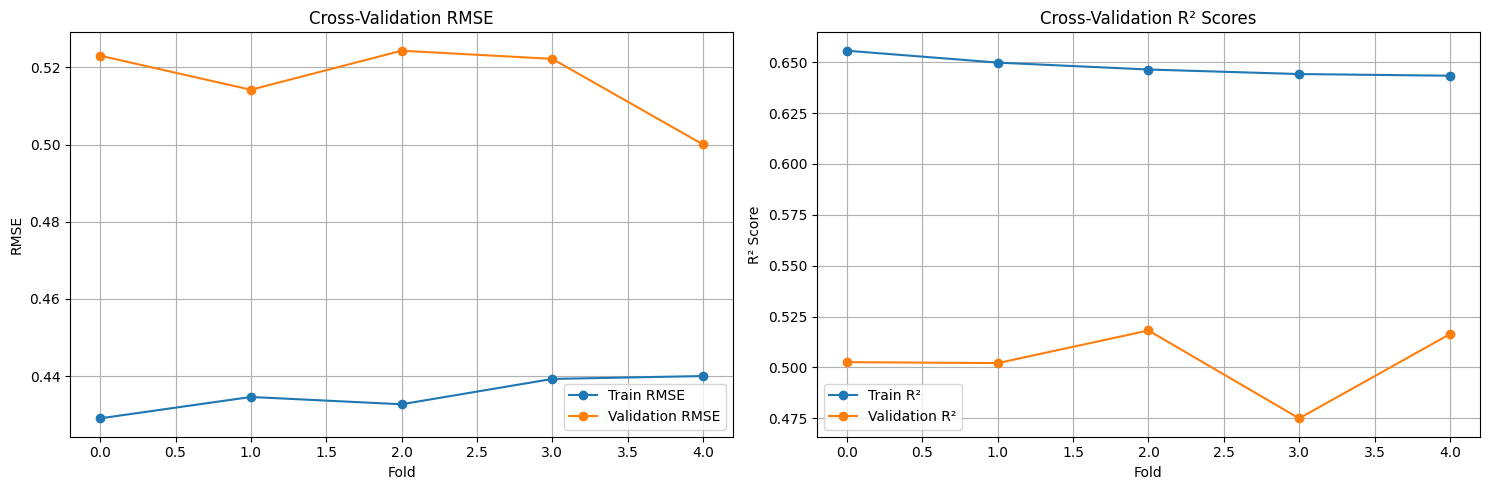


Training final mapping model with 479 rounds on ALL data...

Saving results...
Done!

Plotting feature importance...


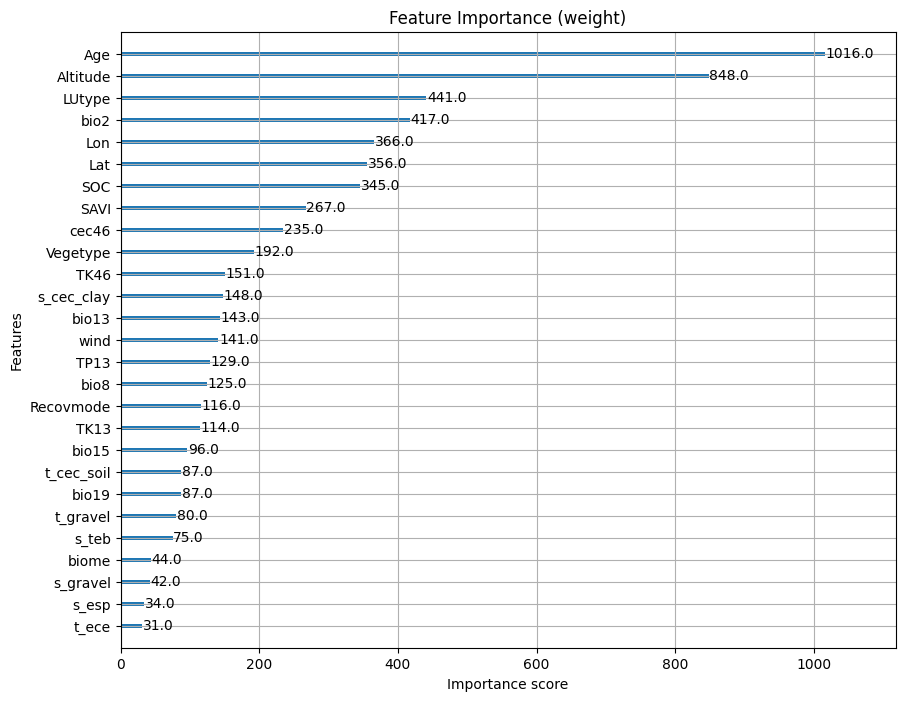

In [76]:
#Mapping LI model
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'lambda': trial.suggest_float('lambda', 5, 20.0),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax, max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

# These functions should be OUTSIDE the class
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)
    
    target_layer = "subsoil"#######################################################################change layer here
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models'
    )

    # ✅ Unbiased test evaluation
    dtrain_final = xgb.DMatrix(
        X_train, label=y_train, feature_names=X_train.columns.tolist()
    )
    temp_model, _ = tuner.train_model(
        best_params, dtrain_final,
        num_boost_round=int(np.mean(cv_results['best_iterations']))
    )
    test_metrics, _ = tuner.evaluate_model(temp_model, dtest)
    print("\n=== Final Test Metrics (unbiased) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # 3. Train final model on ALL data
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final mapping model with {optimal_rounds} rounds on ALL data...")
    dtrain_all = xgb.DMatrix(
        x1, label=y1, feature_names=x1.columns.tolist()
    )
    final_model, evals_result = tuner.train_model(
        best_params, dtrain_all,
        num_boost_round=optimal_rounds
    )

    # Save results
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")

    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)

    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)

if __name__ == "__main__":
    main()

In [35]:

import xgboost as xgb
import pandas as pd

# Configuration
model_path = 'F:/model/results/xgb_model.json'##########replace wiht your directions
features_path = 'F:/model/Mapping_select_features.csv'

# 1. Load model and original features
xgb_model = xgb.Booster()
xgb_model.load_model(model_path)
original_features = xgb_model.feature_names
print("Original model features:", original_features)

# 2. Load your feature mapping CSV
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
print("\nFeatures from CSV:", feature_columns)

# 3. Create feature name mapping (adjust as needed)
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13'
}

# 4. Map original features to new names
updated_features = [
    feature_mapping.get(feat, feat)  # Use mapped name if exists, else original
    for feat in original_features
]

# 5. Validate feature availability
available_features = set(feature_columns)
required_features = set(updated_features)

missing_features = required_features - available_features
if missing_features:
    print("\nWARNING: Missing features:")
    for feat in sorted(missing_features):
        print(f"- {feat}")
    
    # Option 1: Fill with defaults (modify as needed)
    # for feat in missing_features:
    #     feature_columns.append(feat)  # Add missing features
    
    # Option 2: Raise error
    raise ValueError(f"{len(missing_features)} required features missing in CSV")

# 6. Update model with new feature names
xgb_model.feature_names = updated_features
print("\nSuccessfully updated model features:", xgb_model.feature_names)

# 7. Ensure prediction data uses these exact features
# prediction_data = input_data[updated_features]  # Must use this order

Original model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'Sand', 'Silt', 'Clay', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']

Features from CSV: ['Lon', 'Lat', 'Landuse_type', 'biome', 'Age', 'Recovery_mode', 'Altitude', 't_bd', 't_ph', 't_sand', 't_silt', 't_clay', 'Vege_type', 't_oc', 'TN13', 'TK13', 'NPP', 'cec46', 'bio2', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']

- MAP
- s_caco3


ValueError: 2 required features missing in CSV

In [ ]:
import glob
import numpy as np
Features=np.sort(glob.glob('F:/model/New_NC/*.nc'))

target_var = "yi"
seed=42

# 将循环体封装成函数
def process_nc(nc_path,Select_features,target_layer,target_carbon):
    try:
        ds_0 = xr.open_dataset(nc_path)
        ds = ds_0.to_dataframe().reset_index(drop=False).rename(columns={'x':'Lon','y':'Lat'})
        ds_0.close()
        ds = ds.rename(columns={
            'x':'Lon',
            'y':'Lat',
            'ForestAge_TC000':'Age',
            'elevation':'Altitude'
        })
        
        Original_xy=ds[['Lon','Lat']].copy()
        """
        if target_carbon=="slow":
            Xpre_name=Select_features[3]
            ds[Xpre_name]=ds[Xpre_name.replace(target_carbon,"active")]+ds[Xpre_name.replace(target_carbon,"passive")]
        """
        ds = ds[Select_features]  # 确保Select_feature_now在作用域内
        ds=ds.dropna()
        xgb_model.feature_names=None  #危险代码 需自行确保模型与输入特征真的顺序一致,这里只是改名
        #ds = ds.loc[~ds['Landuse_type'].isna()]
        #ds = ds.loc[~ds['Age'].isna()]
        if ds.shape[0] == 0:
            Original_xy['Predicted']=np.nan
            return Original_xy
        ds = ds.reset_index(drop=True)
        
        #ds.columns = data_predictor_VIF.T.values[0]  # 确保data_predictor_VIF在作用域内
        
        # 确保xgb_model在作用域内
        #predict_now = xgb_model.predict(xgb.DMatrix(ds[data_predictor_VIF.T.values[0]]))
        predict_now = xgb_model.predict(xgb.DMatrix(ds.values)) #按照训练模型时的用法改编

        results = pd.concat([
            ds[['Lon','Lat']],
            pd.Series(predict_now, name='Predicted'),
        ], axis=1)

        #resume the original x,y and fill missing values with np.nan
        Original_xy['Predicted']=np.nan
        Original_xy=Original_xy.set_index(['Lon','Lat'])
        results=results.set_index(['Lon','Lat'])
        results=results.reindex(Original_xy.index).reset_index(drop=False)
        
        del Original_xy,ds
    except Exception as e:
        print(f"Error processing {nc_path}: {e}")
        raise e
    

    return results
Select_features=pd.read_csv('F:/model/Mapping_select_features.csv',index_col=None,sep=',').T.reset_index(drop=True)

xgb_model=xgb.Booster()
xgb_model.load_model(f'F:/model/results/xgb_model.json')
target_carbon = "passive"
target_layer = "topsoil"                                                                    
All_results = Parallel(n_jobs=17 ,verbose=10)(  # n_jobs=-1表示使用所有CPU核心
    delayed(process_nc)(nc_path,Select_features.values[0],target_layer,target_carbon) for nc_path in Features
)

# 合并结果（与原代码保持一致）
All_results = pd.concat(All_results, axis=0).reset_index(drop=True)
All_results=All_results.rename(columns={'Lon':'x','Lat':'y','Predicted':f'{target_carbon}_{target_layer}'}).set_index(['x','y']).to_xarray().rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs("EPSG:4326").transpose('y', 'x')[f'{target_carbon}_{target_layer}']

All_results.rio.to_raster(f'F:/model/Mapping_{target_carbon}_{target_layer}_newCLIMATE.tif',nodata=np.nan ,compress='LZW')

print(f"Mapping for {target_carbon} carbon in {target_layer} layer is done")

[Parallel(n_jobs=17)]: Using backend LokyBackend with 17 concurrent workers.


ValueError: No objects to concatenate

In [78]:

import os
import numpy as np
import pandas as pd
import xgboost as xgb
import xarray as xr
import rioxarray as rxr
from datetime import datetime
import warnings
import gc
warnings.filterwarnings('ignore', category=UserWarning)

In [81]:
import os
import gc
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== 用户配置部分 =====================
MODEL_PATH = 'F:/model/results/active_top/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/active_top/Mapping_SOC_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = -1  # 可调节线程数
# ======================================================

# 控制线程数
os.environ["OMP_NUM_THREADS"] = str(N_JOBS)

print("📂 正在加载特征列表...")
# 加载特征列表
select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
print(f"✅ 特征列表加载完成，共 {len(select_features)} 个特征")

# 使用 Altitude.tif 作为参考模板
print("📂 正在加载参考图层 Altitude.tif...")
reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
ref_shape = ref_da.shape
coords_x, coords_y = ref_da['x'], ref_da['y']
print(f"✅ 参考图层加载完成，尺寸: {ref_shape}")

# 生成经纬度网格并保存 Lon/Lat tif
print("🗺️ 正在生成 Lon.tif 和 Lat.tif ...")
lon_2d, lat_2d = np.meshgrid(ref_da['x'].values, ref_da['y'].values)
for name, data in zip(['Lon', 'Lat'], [lon_2d, lat_2d]):
    da = xr.DataArray(data, coords=ref_da.coords, dims=ref_da.dims, name=name)
    da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    da = da.rio.write_crs("EPSG:4326")
    da.rio.to_raster(os.path.join(INPUT_TIF_FOLDER, f'{name}.tif'), compress='LZW', nodata=np.nan)
print("✅ Lon.tif 和 Lat.tif 已生成")

# 加载模型
print("🤖 正在加载 XGBoost 模型...")
xgb_model = xgb.Booster()
xgb_model.load_model(MODEL_PATH)
print("✅ 模型加载完成")

# 定义读取函数
def load_feature(feat):
    tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
    if not os.path.exists(tif_path):
        print(f"⚠️ 缺少特征文件: {tif_path}")
        return feat, None
    try:
        da = rxr.open_rasterio(tif_path, masked=True).squeeze()
        if da.shape != ref_shape:
            print(f"⚠️ 尺寸不一致: {feat} ({da.shape} ≠ {ref_shape})")
            return feat, None
        result = da.values.flatten()
        del da
        gc.collect()
        return feat, result
    except Exception as e:
        print(f"❌ 读取错误 {feat}: {e}")
        return feat, None

# 读取特征
print("🔍 正在读取特征图层...")
results = [load_feature(feat) for feat in select_features]
gc.collect()
feature_data = {k: v for k, v in results if v is not None}

# 检查
loaded_feats = set(feature_data.keys())
missing_feats = set(select_features) - loaded_feats
if missing_feats:
    raise ValueError(f"❌ 以下特征文件缺失或读取失败: {missing_feats}")
print(f"✅ 所有特征图层读取完成，共 {len(loaded_feats)} 个")

# 构建 DataFrame
print("📊 正在构建 DataFrame ...")
df = pd.DataFrame(feature_data)
valid_mask = ~df.isnull().any(axis=1)
valid_data = df[valid_mask]
print(f"✅ DataFrame 构建完成，有效像素数: {len(valid_data)} / {df.shape[0]}")

# 预测
print("⚡ 正在进行 XGBoost 预测...")
xgb_model.feature_names = None
dtest = xgb.DMatrix(valid_data.values)
predictions = xgb_model.predict(dtest)
print("✅ 预测完成")

# 填充结果
print("🛠️ 正在构建结果数组...")
result_array = np.full((ref_shape[0] * ref_shape[1],), np.nan)
result_array[valid_mask.values] = predictions
result_array = result_array.reshape(ref_shape)

# 构建 DataArray
print("🛠️ 正在构建 DataArray...")
pred_da = xr.DataArray(
    result_array,
    coords={"y": coords_y, "x": coords_x},
    dims=("y", "x"),
    name=f"{TARGET_CARBON}_{TARGET_LAYER}"
)
pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
pred_da = pred_da.rio.write_crs("EPSG:4326")
pred_da = pred_da.transpose('y', 'x')

# 保存结果
print("💾 正在保存预测结果...")
os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)
print(f"🎉 预测完成，结果已保存到: {OUTPUT_TIF_PATH}")


📂 正在加载特征列表...
✅ 特征列表加载完成，共 33 个特征
📂 正在加载参考图层 Altitude.tif...
✅ 参考图层加载完成，尺寸: (18000, 43200)
🗺️ 正在生成 Lon.tif 和 Lat.tif ...
✅ Lon.tif 和 Lat.tif 已生成
🤖 正在加载 XGBoost 模型...
✅ 模型加载完成
🔍 正在读取特征图层...
❌ 读取错误 t_oc: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 TN13: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 TK13: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 NPP: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 cec46: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 bio2: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 bio5: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 bio8: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type flo

ValueError: ❌ 以下特征文件缺失或读取失败: {'t_oc', 'bio5', 'NPP', 'wind', 't_cec_soil', 't_ece', 'bio2', 's_teb', 't_gravel', 'bio19', 'cec46', 'bio15', 'SAVI', 's_gravel', 'TK13', 'bio18', 'bio8', 'TN13', 's_esp', 's_cec_clay'}

In [ ]:
#重采样
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

# 文件路径
base_path = r"E:/input0905/bio2.tif"
bio7_path = r"E:/input0905/other/bio7.tif"
ai_path = r"E:/input0905/other/AI.tif"
output_dir = r"E:/input0905/other/output_aligned"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 读取基准栅格信息
with rasterio.open(base_path) as base:
    base_profile = base.profile.copy()
    base_data = base.read(1)

# 处理bio7.tif
with rasterio.open(bio7_path) as src:
    # 重采样到基准坐标系
    bio7_aligned = np.empty_like(base_data)
    reproject(
        source=rasterio.band(src, 1),
        destination=bio7_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.bilinear
    )
    
    # 保存重采样结果
    bio7_output = os.path.join(output_dir, "aligned_bio7.tif")
    with rasterio.open(bio7_output, 'w', **base_profile) as dst:
        dst.write(bio7_aligned, 1)

# 处理AI.tif
with rasterio.open(ai_path) as src:
    # 重采样到基准坐标系
    ai_aligned = np.empty_like(base_data)
    reproject(
        source=rasterio.band(src, 1),
        destination=ai_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.nearest
    )
    
    # 保存重采样结果
    ai_output = os.path.join(output_dir, "aligned_AI.tif")
    with rasterio.open(ai_output, 'w', **base_profile) as dst:
        dst.write(ai_aligned, 1)

# 应用AI掩膜
with rasterio.open(ai_output) as ai_src:
    ai_mask = ai_src.read(1)
    
    # 对bio7应用掩膜
    with rasterio.open(bio7_output) as bio7_src:
        bio7_masked = bio7_src.read(1)
        bio7_masked[ai_mask == ai_src.nodata] = bio7_src.nodata
        
        # 保存掩膜后的bio7
        bio7_masked_output = os.path.join(output_dir, "masked_bio7.tif")
        with rasterio.open(bio7_masked_output, 'w', **base_profile) as dst:
            dst.write(bio7_masked, 1)

print("✅ 处理完成！")
print(f"重采样后的bio7: {os.path.join(output_dir, 'aligned_bio7.tif')}")
print(f"重采样后的AI: {os.path.join(output_dir, 'aligned_AI.tif')}")
print(f"掩膜后的bio7: {os.path.join(output_dir, 'masked_bio7.tif')}")

WarpOperationError: Chunk and warp failed

: 

In [ ]:

# ===================== 用户配置部分 =====================
MODEL_PATH = 'F:/model/results/active_top/xgb_model.json'
FEATURE_CSV_PATH = 'F:/odel/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/input0905'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/active_top/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "active"
TARGET_LAYER = "topsoil"
N_JOBS = -1  # 可调节线程数
# ======================================================

# 控制线程数
os.environ["OMP_NUM_THREADS"] = str(N_JOBS)

print("📂 正在加载特征列表...")
# 加载特征列表
select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
print(f"✅ 特征列表加载完成，共 {len(select_features)} 个特征")

# 使用 Altitude.tif 作为参考模板
print("📂 正在加载参考图层 Altitude.tif...")
reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
ref_shape = ref_da.shape
coords_x, coords_y = ref_da['x'], ref_da['y']
print(f"✅ 参考图层加载完成，尺寸: {ref_shape}")

# 生成经纬度网格并保存 Lon/Lat tif
print("🗺️ 正在生成 Lon.tif 和 Lat.tif ...")
lon_2d, lat_2d = np.meshgrid(ref_da['x'].values, ref_da['y'].values)
for name, data in zip(['Lon', 'Lat'], [lon_2d, lat_2d]):
  da = xr.DataArray(data, coords=ref_da.coords, dims=ref_da.dims, name=name)
da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")
da = da.rio.write_crs("EPSG:4326")
da.rio.to_raster(os.path.join(INPUT_TIF_FOLDER, f'{name}.tif'), compress='LZW', nodata=np.nan)
print("✅ Lon.tif 和 Lat.tif 已生成")

# 加载模型
print("🤖 正在加载 XGBoost 模型...")
xgb_model = xgb.Booster()
xgb_model.load_model(MODEL_PATH)
print("✅ 模型加载完成")

# 定义读取函数
def load_feature(feat):
  tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
if not os.path.exists(tif_path):
  print(f"⚠️ 缺少特征文件: {tif_path}")
return feat, None
try:
  da = rxr.open_rasterio(tif_path, masked=True).squeeze()
if da.shape != ref_shape:
  print(f"⚠️ 尺寸不一致: {feat} ({da.shape} ≠ {ref_shape})")
return feat, None
result = da.values.flatten()
del da
gc.collect()
return feat, result
except Exception as e:
  print(f"❌ 读取错误 {feat}: {e}")
return feat, None

# 读取特征
print("🔍 正在读取特征图层...")
results = [load_feature(feat) for feat in select_features]
gc.collect()
feature_data = {k: v for k, v in results if v is not None}

# 检查
loaded_feats = set(feature_data.keys())
missing_feats = set(select_features) - loaded_feats
if missing_feats:
  raise ValueError(f"❌ 以下特征文件缺失或读取失败: {missing_feats}")
print(f"✅ 所有特征图层读取完成，共 {len(loaded_feats)} 个")

# 构建 DataFrame
print("📊 正在构建 DataFrame ...")
df = pd.DataFrame(feature_data)
valid_mask = ~df.isnull().any(axis=1)
valid_data = df[valid_mask]
print(f"✅ DataFrame 构建完成，有效像素数: {len(valid_data)} / {df.shape[0]}")

# 预测
print("⚡ 正在进行 XGBoost 预测...")
xgb_model.feature_names = None
dtest = xgb.DMatrix(valid_data.values)
predictions = xgb_model.predict(dtest)
print("✅ 预测完成")

# 填充结果
print("🛠️ 正在构建结果数组...")
result_array = np.full((ref_shape[0] * ref_shape[1],), np.nan)
result_array[valid_mask.values] = predictions
result_array = result_array.reshape(ref_shape)

# 构建 DataArray
print("🛠️ 正在构建 DataArray...")
pred_da = xr.DataArray(
  result_array,
  coords={"y": coords_y, "x": coords_x},
  dims=("y", "x"),
  name=f"{TARGET_CARBON}_{TARGET_LAYER}"
)
pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
pred_da = pred_da.rio.write_crs("EPSG:4326")
pred_da = pred_da.transpose('y', 'x')

# 保存结果
print("💾 正在保存预测结果...")

# 确保输出目录存在
os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)

pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)
print(f"🎉 预测完成，结果已保存到: {OUTPUT_TIF_PATH}")


In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os
import glob

# 配置路径
base_path = r"E:/input0905/bio2.tif"
input_dir = r"E:/input0905/other"
ai_path = r"E:/input0905/other/AI.tif"
output_dir = r"E:/input0905/other/output_aligned"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取所有tif文件（排除AI.tif）
tif_files = [f for f in glob.glob(os.path.join(input_dir, "*.tif")) 
            if not f.endswith("AI.tif")]

print(f"处理 {len(tif_files)} 个文件...")

# 读取基准信息
with rasterio.open(base_path) as base:
    base_profile = base.profile.copy()

# 处理AI掩膜
print("处理AI掩膜...")
with rasterio.open(ai_path) as src:
    ai_aligned = np.empty((base_profile['height'], base_profile['width']), 
                         dtype=base_profile['dtype'])
    
    reproject(
        source=rasterio.band(src, 1),
        destination=ai_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.nearest,
        warp_mem_limit=512
    )

# 处理所有文件
for tif_path in tif_files:
    file_name = os.path.basename(tif_path)
    print(f"处理: {file_name}")
    
    try:
        with rasterio.open(tif_path) as src:
            # 重采样
            aligned_data = np.empty((base_profile['height'], base_profile['width']), 
                                   dtype=base_profile['dtype'])
            
            reproject(
                source=rasterio.band(src, 1),
                destination=aligned_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=base_profile['transform'],
                dst_crs=base_profile['crs'],
                resampling=Resampling.bilinear,
                warp_mem_limit=512
            )
            
            # 应用掩膜
            if src.nodata is not None:
                aligned_data[ai_aligned == src.nodata] = src.nodata
            else:
                aligned_data[ai_aligned <= 0] = -9999
            
            # 保存最终结果
            output_path = os.path.join(output_dir, file_name)
            with rasterio.open(output_path, 'w', **base_profile) as dst:
                dst.write(aligned_data, 1)
                
    except Exception as e:
        print(f"错误处理 {file_name}: {e}")

print("✅ 完成！所有文件已重采样并应用掩膜")

In [ ]:
#speading
import xgboost as xgb
import pandas as pd
import numpy as np
import glob
import os
from joblib import Parallel, delayed
import rioxarray as rxr
import xarray as xr
import rasterio

# ====== Configuration ======
cv_model_paths = glob.glob('C:/Users/pc/results/cv_models/*.json')
features_path = 'F:/model/Mapping_select_features.csv'
input_tif_folder = 'F:/BaiduNetdiskDownload/Mapping_INPUT'  # 改为TIF文件夹
output_prediction_path = 'F:/model/Mapping_prediction.tif'
output_spread_path = 'F:/model/Mapping_uncertainty_spread.tif'

# ====== Feature Mapping ======
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'Recovery.mode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13',
    'Lon': 'x',
    'Lat': 'y',
    'Age': 'ForestAge_TC000',
    'Altitude': 'elevation'
}

# ====== Load Selected Features ======
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
mapped_features = [feature_mapping.get(f, f) for f in feature_columns]

# ====== Load Models ======
cv_models = []
for path in cv_model_paths:
    model = xgb.Booster()
    model.load_model(path)
    model.feature_names = [feature_mapping.get(f, f) for f in model.feature_names]
    cv_models.append(model)
print(f"Loaded {len(cv_models)} CV models.")
print("select_features:", select_features)
print("mapped_features:", mapped_features)
print("feature_columns:", feature_columns)
print("model feature_names:", cv_models[0].feature_names)

# ====== TIF Processing Function ======
def process_tif_features(tif_folder, features_to_use, core_feature="Recovery_mode"):
    """
    从TIF文件夹读取所有特征数据并合并
    """
    print("Reading TIF files...")
    
    # 读取所有TIF文件
    feature_data_dict = {}
    ref_raster = None
    
    for feat in features_to_use:
        tif_path = os.path.join(tif_folder, f"{feat}.tif")
        if not os.path.exists(tif_path):
            print(f"[Warning] Missing TIF file: {tif_path}")
            continue
            
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)
                if ref_raster is None:
                    ref_raster = src
                    transform = src.transform
                    crs = src.crs
                    height, width = src.height, src.width
                
                # 确保所有TIF尺寸一致
                if data.shape != (height, width):
                    print(f"[Warning] Size mismatch for {feat}: {data.shape} vs ({height}, {width})")
                    continue
                    
                feature_data_dict[feat] = data
                print(f"Loaded: {feat} - shape: {data.shape}")
                
        except Exception as e:
            print(f"[Error] reading {tif_path}: {e}")
            continue
    
    if not feature_data_dict:
        raise ValueError("No valid TIF files found!")
    
    # 检查核心特征
    if core_feature not in feature_data_dict:
        raise ValueError(f"Core feature '{core_feature}' not found in TIF files!")
    
    # 创建坐标网格
    x_coords = np.arange(width) * transform[0] + transform[2] + transform[0] / 2
    y_coords = np.arange(height) * transform[4] + transform[5] + transform[4] / 2
    
    xx, yy = np.meshgrid(x_coords, y_coords)
    feature_data_dict['x'] = xx
    feature_data_dict['y'] = yy
    
    # 有效掩膜（基于核心特征）
    valid_mask = ~np.isnan(feature_data_dict[core_feature])
    
    return feature_data_dict, valid_mask, y_coords, x_coords, transform, crs

# ====== Prediction Function ======
def predict_with_models(feature_data_dict, valid_mask, models):
    """
    使用所有模型进行预测
    """
    model_feature_order = models[0].feature_names
    
    # 按模型要求的特征顺序排列
    feature_arrays = []
    for feat in model_feature_order:
        if feat in feature_data_dict:
            feature_arrays.append(feature_data_dict[feat])
        else:
            raise ValueError(f"Feature {feat} not found in data!")
    
    # 堆叠特征
    feature_stack = np.stack(feature_arrays, axis=-1)
    n_lat, n_lon, n_feat = feature_stack.shape
    X_flat = feature_stack.reshape(-1, n_feat)
    
    # 移除无效像素
    valid_indices = valid_mask.flatten()
    X_valid = X_flat[valid_indices]
    
    if len(X_valid) == 0:
        print("[Warning] No valid pixels for prediction")
        return None, None
    
    # 使用所有模型进行预测
    preds_all = []
    for model in models:
        dmatrix = xgb.DMatrix(X_valid, feature_names=model.feature_names)
        preds = model.predict(dmatrix)
        preds_all.append(preds)
    
    preds_stack = np.stack(preds_all, axis=0)
    mean_pred_valid = np.mean(preds_stack, axis=0)
    std_pred_valid = np.std(preds_stack, axis=0)
    
    # 重建完整图像
    mean_pred_full = np.full(n_lat * n_lon, np.nan)
    std_pred_full = np.full(n_lat * n_lon, np.nan)
    
    mean_pred_full[valid_indices] = mean_pred_valid
    std_pred_full[valid_indices] = std_pred_valid
    
    return (mean_pred_full.reshape(n_lat, n_lon), 
            std_pred_full.reshape(n_lat, n_lon))

# ====== Main ======
if __name__ == "__main__":
    # 处理TIF文件
    feature_data_dict, valid_mask, y_coords, x_coords, transform, crs = process_tif_features(
        input_tif_folder, mapped_features, core_feature="Recovery_mode"
    )
    
    # 进行预测
    mean_pred, std_pred = predict_with_models(feature_data_dict, valid_mask, cv_models)
    
    if mean_pred is None or std_pred is None:
        raise ValueError("Prediction failed!")
    
    # 创建DataArray并保存
    da_mean = xr.DataArray(
        mean_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_std = xr.DataArray(
        std_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    
    # 设置坐标系
    da_mean.rio.write_crs(crs, inplace=True)
    da_std.rio.write_crs(crs, inplace=True)
    da_mean.rio.write_transform(transform, inplace=True)
    da_std.rio.write_transform(transform, inplace=True)
    
    # 保存结果
    da_mean.rio.to_raster(output_prediction_path, compress='LZW', nodata=np.nan)
    da_std.rio.to_raster(output_spread_path, compress='LZW', nodata=np.nan)
    
    print("✅ Prediction completed!")
    print(f"Mean prediction saved to: {output_prediction_path}")
    print(f"Uncertainty spread saved to: {output_spread_path}")
    print(f"Output shape: {mean_pred.shape}")
    print(f"Valid pixels: {np.sum(~np.isnan(mean_pred))} / {mean_pred.size}")




In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import os
from pathlib import Path
from scipy.interpolate import make_interp_spline

# Set font properties to match R's Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

def save_correlation_plot(final_model, X_test, y_test, X_train, y_train, output_path="correlation_plot.tif"):
    """Create correlation plot similar to R code with R² annotation"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 7), dpi=300)
    
    # Plot training set
    ax.scatter(y_train, train_pred, alpha=0.4, s=10, color='black', label='Training set')
    # Add regression line for training
    z_train = np.polyfit(y_train, train_pred, 1)
    p_train = np.poly1d(z_train)
    ax.plot(np.sort(y_train), p_train(np.sort(y_train)), color='black', linewidth=3)
    
    # Plot testing set
    ax.scatter(y_test, test_pred, alpha=0.4, s=10, color='#e08214', label='Testing set')
    # Add regression line for testing
    z_test = np.polyfit(y_test, test_pred, 1)
    p_test = np.poly1d(z_test)
    ax.plot(np.sort(y_test), p_test(np.sort(y_test)), color='#e08214', linewidth=3)
    
    # Add legend with R² values
    legend_text = [
        f'Training set (R² = {train_r2:.3f})',
        f'Testing set (R² = {test_r2:.3f})'
    ]
    ax.legend(legend_text, loc='upper left', frameon=False, fontsize=14)
    
    # Add sample size text
    ax.text(0.05, 0.95, f"n = {len(y_test)}", transform=ax.transAxes, 
            fontsize=14, fontweight='bold', verticalalignment='top')
    
    # Set axis labels
    ax.set_xlabel('Actual Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=14, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add diagonal reference line
    min_val = min(min(y_train), min(y_test))
    max_val = max(max(y_train), max(y_test))
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', alpha=0.7, linewidth=1)
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Correlation plot saved as: {output_path}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    """Create feature importance plot similar to R code"""
    
    # Get feature importance
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')
    
    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    
    # Create DataFrame and sort
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    })
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    
    # Create lollipop plot
    y_pos = np.arange(len(imp_df))
    
    # Draw segments
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)
    
    # Draw points with size proportional to importance
    max_importance = max(imp_df['Importance'])
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    
    ax.scatter(imp_df['Importance'], y_pos, color='#e08214', 
               s=point_sizes, alpha=0.7, zorder=3)
    
    # Set y ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=16, fontweight='bold')
    
    # Set x label
    ax.set_xlabel('Importance', fontsize=18, fontweight='bold')
    
    # Remove unnecessary elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', left=False)
    
    # Add reference lines
    if max_importance > 0.5:
        ax.axvline(x=0.5, color='black', linewidth=1, linestyle='--', alpha=0.5)
    ax.axhline(y=-0.5, color='black', linewidth=1, linestyle='--', alpha=0.5)
    
    # Remove grid
    ax.grid(False)
    
    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Importance plot saved as: {output_path}")

def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    """Manual implementation of partial dependence plots"""
    X_temp = X.copy()
    
    # Create grid of values for the feature
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    
    return feature_values, np.array(predictions)

def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    """Create Partial Dependence Plot for specific features with smooth lines"""
    
    # Define the specific features to plot
    target_features = ['Age', 'pH', 'Silt', 'Clay', 'Altitude', 'Latitude']
    
    # Check which features are available in the data
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data. Available features:")
        print(X_train.columns.tolist())
        return
    
    print(f"Creating PDP for features: {available_features}")
    
    # Define colors similar to R code
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#FF7F00", "#33A02C"]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)
    
    # Calculate partial dependence for each specified feature
    for i, feature in enumerate(available_features):
        if i < len(colors):
            print(f"Calculating partial dependence for {feature}...")
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            
            # Normalize x values to 0-50 range for consistent plotting
            x_normalized = np.linspace(0, 50, len(feature_values))
            
            # Create smooth curve using spline interpolation
            if len(feature_values) > 3:
                try:
                    # Create smooth curve with more points
                    x_smooth = np.linspace(x_normalized.min(), x_normalized.max(), 500)
                    spl = make_interp_spline(x_normalized, predictions, k=3)
                    y_smooth = spl(x_smooth)
                    
                    # Plot smooth curve
                    ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=4, alpha=0.8, label=feature)
                except Exception as e:
                    print(f"Spline failed for {feature}: {e}")
                    # Fallback to simple line plot if spline fails
                    ax.plot(x_normalized, predictions, color=colors[i], linewidth=4, alpha=0.8, label=feature)
            else:
                ax.plot(x_normalized, predictions, color=colors[i], linewidth=4, alpha=0.8, label=feature)
    
    # Customize the plot to match R style
    ax.set_xlabel('Feature Value (Normalized)', fontsize=25, fontweight='bold')
    ax.set_ylabel('Partial Dependence', fontsize=25, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=22, width=1.5)
    
    # Customize x-axis ticks to show "Low" and "High"
    xlim = ax.get_xlim()
    ax.set_xticks([xlim[0], xlim[1]])
    ax.set_xticklabels(['Low', 'High'], fontsize=20, fontweight='bold')
    
    # Set y-axis ticks with better formatting
    ylim = ax.get_ylim()
    y_ticks = np.linspace(ylim[0], ylim[1], 5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks], fontsize=20, fontweight='bold')
    
    # Set border
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Remove grid
    ax.grid(False)
    
    # Create legend (positioned like R code)
    ax.legend(loc='upper left', 
              bbox_to_anchor=(0.4, 0.8),
              frameon=False,
              fontsize=18,
              handlelength=1.5,
              handletextpad=0.8)
    
    # Set white background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Partial dependence plot saved as: {output_path}")

def save_shap_summary_plot(final_model, X_test, top_n=15, output_path="shap_summary.tif"):
    """Create SHAP summary plot as an alternative"""
    try:
        import shap
        
        print("Generating SHAP summary plot...")
        # Create explainer
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        
        # Create figure
        plt.figure(figsize=(10, 8), dpi=300)
        
        # Create summary plot
        shap.summary_plot(shap_values, X_test, show=False, max_display=top_n, plot_size=None)
        
        # Customize appearance
        plt.gcf().set_facecolor('white')
        plt.tight_layout()
        
        # Save as TIFF
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.close()
        
        print(f"SHAP summary plot saved as: {output_path}")
        
    except ImportError:
        print("SHAP not available. Install with: pip install shap")

def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    """Save training and testing sets"""
    Path(output_dir).mkdir(exist_ok=True)
    
    # Save as CSV files
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    
    print(f"Training and testing sets saved in: {output_dir}")

def save_model(final_model, output_path="final_xgboost_model.json"):
    """Save the trained model"""
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")

# Modified main function to include plotting with explicit output paths
def main_with_plots():
    # Create results directory
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    
    # Load and prepare data (using your existing function)
    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )
    
    # Save training and testing sets
    save_training_testing_sets(X_train, y_train, X_test, y_test)
    
    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
    
    # Save the model
    save_model(final_model, "F:/model/results/final_xgboost_model.json")
    
    # Create and save plots with explicit output paths
    print("\nCreating and saving plots...")
    
    # 1. Correlation plot with R²
    print("Creating correlation plot with R²...")
    correlation_path = os.path.join(results_dir, "correlation_plot.tif")
    save_correlation_plot(final_model, X_test, y_test, X_train, y_train, correlation_path)
    
    # 2. Importance plot (top 15 features)
    print("Creating importance plot...")
    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)
    
    # 3. Partial Dependence Plot for specific features with smooth lines
    print("Creating partial dependence plot for Age, pH, Silt, Clay, Altitude, Latitude...")
    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)
    
    # 4. SHAP summary plot as alternative
    print("Creating SHAP summary plot...")
    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, top_n=15, output_path=shap_path)
    
    # Evaluate model
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    
    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")

if __name__ == "__main__":
    main_with_plots()

Loading and preparing data...


E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-10-12 17:02:28,376] A new study created in memory with name: no-name-33c18cf3-ec09-4c81-ab1e-d1152fd5274f


Training and testing sets saved in: saved_data
Starting optimized hyperparameter tuning...


[I 2025-10-12 17:02:31,666] Trial 0 finished with value: 0.5085698901934427 and parameters: {'eta': 0.1519525205210199, 'max_depth': 3, 'subsample': 0.6889349933853753, 'colsample_bytree': 0.7920246273296672, 'min_child_weight': 7, 'lambda': 4.860190165537677, 'alpha': 1.4957791322785194, 'gamma': 0.08341151019182202}. Best is trial 0 with value: 0.5085698901934427.
[I 2025-10-12 17:02:33,161] Trial 1 finished with value: 0.5000521876476399 and parameters: {'eta': 0.15046536541643182, 'max_depth': 6, 'subsample': 0.6099297154559565, 'colsample_bytree': 0.80049074792737, 'min_child_weight': 5, 'lambda': 8.106070798128709, 'alpha': 1.0421595312533063, 'gamma': 0.13446955622884643}. Best is trial 1 with value: 0.5000521876476399.
[I 2025-10-12 17:02:34,655] Trial 2 finished with value: 0.5015923886206288 and parameters: {'eta': 0.1853881280746715, 'max_depth': 6, 'subsample': 0.6889880508231843, 'colsample_bytree': 0.7556943618696248, 'min_child_weight': 3, 'lambda': 5.195452165044951, 'a


Running optimized cross-validation and saving CV models...

Training final model with 203 rounds...
Model saved as: F:/model/results/final_xgboost_model.json

Creating and saving plots...
Creating correlation plot with R²...
Correlation plot saved as: F:/model/results/plots\correlation_plot.tif
Training R²: 0.6849
Testing R²: 0.6461
Creating importance plot...
Importance plot saved as: F:/model/results/plots\importance_plot.tif
Creating partial dependence plot for Age, pH, Silt, Clay, Altitude, Latitude...
Creating PDP for features: ['Age', 'pH', 'Silt', 'Clay', 'Altitude']
Calculating partial dependence for Age...
Calculating partial dependence for pH...
Calculating partial dependence for Silt...
Calculating partial dependence for Clay...
Calculating partial dependence for Altitude...
Partial dependence plot saved as: F:/model/results/plots\pd_plot.tif
Creating SHAP summary plot...
SHAP not available. Install with: pip install shap

=== Final Test Metrics ===
RMSE: 0.4591
R²: 0.6461


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import os
from pathlib import Path
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set font properties to match R's Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    """Create actual vs predicted plot with fitting lines and combined legend"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Plot training set with fitting line
    train_scatter = ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    # Add fitting line for training set
    z_train = np.polyfit(y_train, train_pred, 1)
    p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train)
    train_line, = ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)
    
    # Plot testing set with fitting line
    test_scatter = ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#e08214', label=f'Testing set (R² = {test_r2:.3f})')
    # Add fitting line for testing set
    z_test = np.polyfit(y_test, test_pred, 1)
    p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test)
    test_line, = ax.plot(test_sorted, p_test(test_sorted), color='#e08214', linewidth=2)
    
    # Add perfect prediction line
    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.7, label='Perfect fit')
    
    # Create combined legend (points and lines together)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e08214', markersize=8, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=25)
    
    # Set labels
    ax.set_xlabel('Actual Values', fontsize=25, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=25
                  , fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid for better readability
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor ('white')
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Actual vs Predicted plot with fitting lines saved as: {output_path}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    """Create residual plot with combined legend"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Calculate residuals
    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Plot residuals with combined legend
    train_scatter = ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    test_scatter = ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#e08214', label='Testing set')
    
    # Add fitting lines for residual patterns
    train_trend_line = None
    test_trend_line = None
    
    # Training set residual trend
    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        train_trend_line, = ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, 
                linestyle='--', alpha=0.7)
    
    # Testing set residual trend
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        test_trend_line, = ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#e08214', linewidth=2, 
                linestyle='--', alpha=0.7)
    
    # Add zero reference line
    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    
    # Create combined legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e08214', markersize=8, label='Testing set'),
        zero_line
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    
    # Set labels
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Residual plot saved as: {output_path}")

def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    """Plot and save cross-validation results"""
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    
    # Plot 1: RMSE across folds
    folds = range(1, len(cv_results['train_rmse']) + 1)
    train_rmse_line, = ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    val_rmse_line, = ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#e08214', linewidth=2, markersize=8, label='Validation RMSE')
    
    # Add fitting lines for trends
    if len(folds) > 1:
        # Fit polynomial trend lines
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse)
        p_val_rmse = np.poly1d(z_val_rmse)
        
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#e08214', alpha=0.5, linewidth=1)
    
    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')
    
    # Plot 2: R² across folds
    train_r2_line, = ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    val_r2_line, = ax2.plot(folds, cv_results['val_r2'], 'o-', color='#e08214', linewidth=2, markersize=8, label='Validation R²')
    
    # Add fitting lines for trends
    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2)
        p_val_r2 = np.poly1d(z_val_r2)
        
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#e08214', alpha=0.5, linewidth=1)
    
    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')
    
    # Plot 3: Best iterations across folds
    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    
    # Add average line
    avg_iterations = np.mean(cv_results['best_iterations'])
    avg_line = ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, 
                label=f'Average: {avg_iterations:.1f}')
    
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')
    
    # Plot 4: Performance summary
    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [
        np.mean(cv_results['train_rmse']),
        np.mean(cv_results['val_rmse']),
        np.mean(cv_results['train_r2']),
        np.mean(cv_results['val_r2'])
    ]
    stds = [
        np.std(cv_results['train_rmse']),
        np.std(cv_results['val_rmse']),
        np.std(cv_results['train_r2']),
        np.std(cv_results['val_r2'])
    ]
    
    colors = ['black', '#e08214', 'black', '#e08214']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Cross-validation results plot saved as: {output_path}")

def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    """Create feature importance plot similar to R code"""
    
    # Get feature importance
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')
    
    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    
    # Create DataFrame and sort
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    })
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    
    # Create lollipop plot
    y_pos = np.arange(len(imp_df))
    
    # Draw segments
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)
    
    # Draw points with size proportional to importance
    max_importance = max(imp_df['Importance'])
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    
    ax.scatter(imp_df['Importance'], y_pos, color='#e08214', 
               s=point_sizes, alpha=0.7, zorder=3)
    
    # Set y ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=16, fontweight='bold')
    
    # Set x label
    ax.set_xlabel('Importance', fontsize=18, fontweight='bold')
    
    # Remove unnecessary elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', left=False)
    
    # Add reference lines
    if max_importance > 0.5:
        ax.axvline(x=0.5, color='black', linewidth=1, linestyle='--', alpha=0.8)
    ax.axhline(y=-0.5, color='black', linewidth=1, linestyle='--', alpha=0.8)
    
    # Remove grid
    ax.grid(False)
    
    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Importance plot saved as: {output_path}")

def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    """Manual implementation of partial dependence plots"""
    X_temp = X.copy()
    
    # Create grid of values for the feature
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    
    return feature_values, np.array(predictions)

def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    """Create Partial Dependence Plot using LOESS smoothing like R's geom_smooth"""
    
    # Define the specific features to plot
    target_features = ['Age', 'pH', 'Silt', 'Clay', 'Altitude', 'Latitude']
    
    # Check which features are available in the data
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data. Available features:")
        print(X_train.columns.tolist())
        return
    
    print(f"Creating PDP for features: {available_features}")
    
    # Define colors similar to R code
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#FF7F00", "#33A02C"]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)
    
    # Calculate partial dependence for each specified feature
    for i, feature in enumerate(available_features):
        if i < len(colors):
            print(f"Calculating partial dependence for {feature}...")
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            
            # Normalize x values to 0-50 range for consistent plotting
            x_normalized = np.linspace(0, 50, len(feature_values))
            
            # Use LOESS smoothing (equivalent to R's geom_smooth method='loess')
            try:
                # Apply LOESS smoothing
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)  # frac=0.3 for smoothness
                x_smooth = smoothed[:, 0]
                y_smooth = smoothed[:, 1]
                
                # Plot LOESS smoothed curve
                ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                
            except Exception as e:
                print(f"LOESS smoothing failed for {feature}: {e}")
                # Fallback to simple line plot
                ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)
    
    # Customize the plot to match R style
    ax.set_xlabel('', fontsize=25, fontweight='bold')
    ax.set_ylabel('', fontsize=25, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=28, width=1.5)
    
    # Customize x-axis ticks to show "Low" and "High"
    xlim = ax.get_xlim()
    ax.set_xticks([xlim[0], xlim[1]])
    ax.set_xticklabels(['Low', 'High'], fontsize=24, fontweight='bold')
    
    # Set border
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Remove grid
    ax.grid(False)
    
    # Create legend (positioned like R code)
    ax.legend(loc='upper left', 
              bbox_to_anchor=(0.15, 0.2),
              frameon=False,
              fontsize=20,
              handlelength=1.5,
              handletextpad=0.5)
    
    # Set white background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Partial dependence plot saved as: {output_path}")

def save_shap_summary_plot(final_model, X_test, output_path="shap_summary.tif"):
    """Create and save SHAP summary plot"""
    try:
        import shap
        
        print("Generating SHAP summary plot...")
        
        # Create explainer
        explainer = shap.TreeExplainer(final_model)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test)
        
        # Create figure with specific size
        plt.figure(figsize=(12, 10), dpi=300)
        
        # Create summary plot
        shap.summary_plot(shap_values, X_test, show=False, max_display=20, plot_size=None)
        
        # Customize appearance
        plt.gcf().set_facecolor('white')
        plt.tight_layout()
        
        # Save as TIFF
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.close()
        
        print(f"SHAP summary plot saved as: {output_path}")
        
    except ImportError:
        print("SHAP not available. Install with: pip install shap")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")

def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    """Save training and testing sets"""
    Path(output_dir).mkdir(exist_ok=True)
    
    # Save as CSV files
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    
    print(f"Training and testing sets saved in: {output_dir}")

def save_model(final_model, output_path="final_xgboost_model.json"):
    """Save the trained model"""
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")

# Modified main function to include plotting with explicit output paths
def main_with_plots():
    # Create results directory
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    
    # Load and prepare data (using your existing function)
    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )
    
    # Save training and testing sets
    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")
    
    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    # Save cross-validation results plot
    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)
    
    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
    
    # Save the model
    save_model(final_model, "F:/model/results/final_xgboost_model.json")
    
    # Create and save plots with explicit output paths
    print("\nCreating and saving plots...")
    
    # 1. Actual vs Predicted plot with fitting lines
    print("Creating actual vs predicted plot with fitting lines...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)
    
    # 2. Residual plot
    print("Creating residual plot...")
    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)
    
    # 3. Importance plot (top 15 features)
    print("Creating importance plot...")
    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)
    
    # 4. Partial Dependence Plot with LOESS smoothing
    print("Creating partial dependence plot with LOESS smoothing...")
    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)
    
    # 5. SHAP summary plot
    print("Creating SHAP summary plot...")
    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, output_path=shap_path)
    
    # Evaluate model
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    
    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")

if __name__ == "__main__":
    main_with_plots()

Loading and preparing data...


E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-10-12 18:43:48,803] A new study created in memory with name: no-name-93c68ea3-d36f-4019-a758-a76cdb20ca42


Training and testing sets saved in: F:/model/results/saved_data
Starting optimized hyperparameter tuning...


[I 2025-10-12 18:43:50,649] Trial 0 finished with value: 0.28759045906039976 and parameters: {'eta': 0.0660966095745996, 'max_depth': 3, 'subsample': 0.6666769203361596, 'colsample_bytree': 0.7476709883998068, 'min_child_weight': 3, 'lambda': 9.253173854165219, 'alpha': 1.0776977257546405, 'gamma': 0.11087100313128749}. Best is trial 0 with value: 0.28759045906039976.
[I 2025-10-12 18:43:52,241] Trial 1 finished with value: 0.27204938192161526 and parameters: {'eta': 0.056011075176154806, 'max_depth': 6, 'subsample': 0.7840401235641075, 'colsample_bytree': 0.8854352370355763, 'min_child_weight': 6, 'lambda': 8.380293030706815, 'alpha': 0.7612211677312535, 'gamma': 0.12708013524284226}. Best is trial 1 with value: 0.27204938192161526.
[I 2025-10-12 18:43:52,960] Trial 2 finished with value: 0.28754792760174647 and parameters: {'eta': 0.17427197080610424, 'max_depth': 4, 'subsample': 0.7180667070695631, 'colsample_bytree': 0.8451289371119821, 'min_child_weight': 3, 'lambda': 7.8945657458


Running optimized cross-validation and saving CV models...
Creating cross-validation results plot...
Cross-validation results plot saved as: F:/model/results/plots\cv_results.tif

Training final model with 92 rounds...
Model saved as: F:/model/results/final_xgboost_model.json

Creating and saving plots...
Creating actual vs predicted plot with fitting lines...
Actual vs Predicted plot with fitting lines saved as: F:/model/results/plots\actual_vs_predicted.tif
Training R²: 0.8886
Testing R²: 0.8153
Creating residual plot...
Residual plot saved as: F:/model/results/plots\residual_plot.tif
Creating importance plot...
Importance plot saved as: F:/model/results/plots\importance_plot.tif
Creating partial dependence plot with LOESS smoothing...
Creating PDP for features: ['Age', 'pH', 'Silt', 'Clay', 'Altitude']
Calculating partial dependence for Age...
Calculating partial dependence for pH...
Calculating partial dependence for Silt...
Calculating partial dependence for Clay...
Calculating p

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import os
from pathlib import Path
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set font properties to match R's Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    """Create actual vs predicted plot with fitting lines and combined legend"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Plot training set with fitting line
    train_scatter = ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    # Add fitting line for training set
    z_train = np.polyfit(y_train, train_pred, 1)
    p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train)
    train_line, = ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)
    
    # Plot testing set with fitting line
    test_scatter = ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#698B69', label=f'Testing set (R² = {test_r2:.3f})')
    # Add fitting line for testing set
    z_test = np.polyfit(y_test, test_pred, 1)
    p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test)
    test_line, = ax.plot(test_sorted, p_test(test_sorted), color='#698B69', linewidth=2)
    
    # Add perfect prediction line
    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.7, label='Perfect fit')
    
    # Create combined legend (points and lines together)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#698B69', markersize=8, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=25)
    
    # Set labels
    ax.set_xlabel('Actual Values', fontsize=25, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=25
                  , fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid for better readability
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor ('white')
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Actual vs Predicted plot with fitting lines saved as: {output_path}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    """Create residual plot with combined legend"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Calculate residuals
    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Plot residuals with combined legend
    train_scatter = ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    test_scatter = ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#698B69', label='Testing set')
    
    # Add fitting lines for residual patterns
    train_trend_line = None
    test_trend_line = None
    
    # Training set residual trend
    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        train_trend_line, = ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, 
                linestyle='--', alpha=0.7)
    
    # Testing set residual trend
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        test_trend_line, = ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#698B69', linewidth=2, 
                linestyle='--', alpha=0.7)
    
    # Add zero reference line
    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    
    # Create combined legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#698B69', markersize=8, label='Testing set'),
        zero_line
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    
    # Set labels
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Residual plot saved as: {output_path}")

def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    """Plot and save cross-validation results"""
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    
    # Plot 1: RMSE across folds
    folds = range(1, len(cv_results['train_rmse']) + 1)
    train_rmse_line, = ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    val_rmse_line, = ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#698B69', linewidth=2, markersize=8, label='Validation RMSE')
    
    # Add fitting lines for trends
    if len(folds) > 1:
        # Fit polynomial trend lines
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse)
        p_val_rmse = np.poly1d(z_val_rmse)
        
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#698B69', alpha=0.5, linewidth=1)
    
    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')
    
    # Plot 2: R² across folds
    train_r2_line, = ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    val_r2_line, = ax2.plot(folds, cv_results['val_r2'], 'o-', color='#698B69', linewidth=2, markersize=8, label='Validation R²')
    
    # Add fitting lines for trends
    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2)
        p_val_r2 = np.poly1d(z_val_r2)
        
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#698B69', alpha=0.5, linewidth=1)
    
    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')
    
    # Plot 3: Best iterations across folds
    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    
    # Add average line
    avg_iterations = np.mean(cv_results['best_iterations'])
    avg_line = ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, 
                label=f'Average: {avg_iterations:.1f}')
    
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')
    
    # Plot 4: Performance summary
    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [
        np.mean(cv_results['train_rmse']),
        np.mean(cv_results['val_rmse']),
        np.mean(cv_results['train_r2']),
        np.mean(cv_results['val_r2'])
    ]
    stds = [
        np.std(cv_results['train_rmse']),
        np.std(cv_results['val_rmse']),
        np.std(cv_results['train_r2']),
        np.std(cv_results['val_r2'])
    ]
    
    colors = ['black', '#698B69', 'black', '#698B69']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Cross-validation results plot saved as: {output_path}")

def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    """Create feature importance plot similar to R code"""
    
    # Get feature importance
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')
    
    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    
    # Create DataFrame and sort
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    })
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    
    # Create lollipop plot
    y_pos = np.arange(len(imp_df))
    
    # Draw segments
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)
    
    # Draw points with size proportional to importance
    max_importance = max(imp_df['Importance'])
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    
    ax.scatter(imp_df['Importance'], y_pos, color='#698B69', 
               s=point_sizes, alpha=0.7, zorder=3)
    
    # Set y ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=16, fontweight='bold')
    
    # Set x label
    ax.set_xlabel('Importance', fontsize=18, fontweight='bold')
    
    # Remove unnecessary elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', left=False)
    
    # Add reference lines
    if max_importance > 0.5:
        ax.axvline(x=0.5, color='black', linewidth=1, linestyle='--', alpha=0.8)
    ax.axhline(y=-0.5, color='black', linewidth=1, linestyle='--', alpha=0.8)
    
    # Remove grid
    ax.grid(False)
    
    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Importance plot saved as: {output_path}")

def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    """Manual implementation of partial dependence plots"""
    X_temp = X.copy()
    
    # Create grid of values for the feature
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    
    return feature_values, np.array(predictions)

def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    """Create Partial Dependence Plot using LOESS smoothing like R's geom_smooth"""
    
    # Define the specific features to plot
    target_features = ['Age', 'pH', 'Silt', 'Clay', 'Altitude', 'Latitude']
    
    # Check which features are available in the data
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data. Available features:")
        print(X_train.columns.tolist())
        return
    
    print(f"Creating PDP for features: {available_features}")
    
    # Define colors similar to R code
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#FF7F00", "#33A02C"]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)
    
    # Calculate partial dependence for each specified feature
    for i, feature in enumerate(available_features):
        if i < len(colors):
            print(f"Calculating partial dependence for {feature}...")
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            
            # Normalize x values to 0-50 range for consistent plotting
            x_normalized = np.linspace(0, 50, len(feature_values))
            
            # Use LOESS smoothing (equivalent to R's geom_smooth method='loess')
            try:
                # Apply LOESS smoothing
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)  # frac=0.3 for smoothness
                x_smooth = smoothed[:, 0]
                y_smooth = smoothed[:, 1]
                
                # Plot LOESS smoothed curve
                ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                
            except Exception as e:
                print(f"LOESS smoothing failed for {feature}: {e}")
                # Fallback to simple line plot
                ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)
    
    # Customize the plot to match R style
    ax.set_xlabel('', fontsize=25, fontweight='bold')
    ax.set_ylabel('', fontsize=25, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=28, width=1.5)
    
    # Customize x-axis ticks to show "Low" and "High"
    xlim = ax.get_xlim()
    ax.set_xticks([xlim[0], xlim[1]])
    ax.set_xticklabels(['Low', 'High'], fontsize=24, fontweight='bold')
    
    # Set border
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Remove grid
    ax.grid(False)
    
    # Create legend (positioned like R code)
    ax.legend(loc='upper left', 
              bbox_to_anchor=(0.15, 0.2),
              frameon=False,
              fontsize=20,
              handlelength=1.5,
              handletextpad=0.5)
    
    # Set white background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Partial dependence plot saved as: {output_path}")

def save_shap_summary_plot(final_model, X_test, output_path="shap_summary.tif"):
    """Create and save SHAP summary plot"""
    try:
        import shap
        
        print("Generating SHAP summary plot...")
        
        # Create explainer
        explainer = shap.TreeExplainer(final_model)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test)
        
        # Create figure with specific size
        plt.figure(figsize=(12, 10), dpi=300)
        
        # Create summary plot
        shap.summary_plot(shap_values, X_test, show=False, max_display=20, plot_size=None)
        
        # Customize appearance
        plt.gcf().set_facecolor('white')
        plt.tight_layout()
        
        # Save as TIFF
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.close()
        
        print(f"SHAP summary plot saved as: {output_path}")
        
    except ImportError:
        print("SHAP not available. Install with: pip install shap")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")

def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    """Save training and testing sets"""
    Path(output_dir).mkdir(exist_ok=True)
    
    # Save as CSV files
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    
    print(f"Training and testing sets saved in: {output_dir}")

def save_model(final_model, output_path="final_xgboost_model.json"):
    """Save the trained model"""
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")

# Modified main function to include plotting with explicit output paths
def main_with_plots():
    # Create results directory
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    
    # Load and prepare data (using your existing function)
    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )
    
    # Save training and testing sets
    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")
    
    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    # Save cross-validation results plot
    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)
    
    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
    
    # Save the model
    save_model(final_model, "F:/model/results/final_xgboost_model.json")
    
    # Create and save plots with explicit output paths
    print("\nCreating and saving plots...")
    
    # 1. Actual vs Predicted plot with fitting lines
    print("Creating actual vs predicted plot with fitting lines...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)
    
    # 2. Residual plot
    print("Creating residual plot...")
    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)
    
    # 3. Importance plot (top 15 features)
    print("Creating importance plot...")
    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)
    
    # 4. Partial Dependence Plot with LOESS smoothing
    print("Creating partial dependence plot with LOESS smoothing...")
    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)
    
    # 5. SHAP summary plot
    print("Creating SHAP summary plot...")
    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, output_path=shap_path)
    
    # Evaluate model
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    
    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")

if __name__ == "__main__":
    main_with_plots()

Loading and preparing data...


E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-10-12 18:47:23,062] A new study created in memory with name: no-name-4a31f4d7-cf98-4231-8829-b96f527a39e1


Training and testing sets saved in: F:/model/results/saved_data
Starting optimized hyperparameter tuning...


[I 2025-10-12 18:47:25,407] Trial 0 finished with value: 0.2767508646534072 and parameters: {'eta': 0.030274302921380766, 'max_depth': 5, 'subsample': 0.7682507109184175, 'colsample_bytree': 0.7733287263387257, 'min_child_weight': 7, 'lambda': 4.619936000654662, 'alpha': 1.1765783599875723, 'gamma': 0.11502505726011221}. Best is trial 0 with value: 0.2767508646534072.
[I 2025-10-12 18:47:27,776] Trial 1 finished with value: 0.27958017991430634 and parameters: {'eta': 0.03519516300826288, 'max_depth': 4, 'subsample': 0.7902473844323469, 'colsample_bytree': 0.8365694988944841, 'min_child_weight': 7, 'lambda': 9.951877895394244, 'alpha': 1.1110484894236372, 'gamma': 0.07708894894305074}. Best is trial 0 with value: 0.2767508646534072.
[I 2025-10-12 18:47:32,316] Trial 2 finished with value: 0.2735195568216286 and parameters: {'eta': 0.011942355637430551, 'max_depth': 6, 'subsample': 0.7686844571724193, 'colsample_bytree': 0.8949091936770857, 'min_child_weight': 3, 'lambda': 5.174290391949


Running optimized cross-validation and saving CV models...
Creating cross-validation results plot...
Cross-validation results plot saved as: F:/model/results/plots\cv_results.tif

Training final model with 112 rounds...
Model saved as: F:/model/results/final_xgboost_model.json

Creating and saving plots...
Creating actual vs predicted plot with fitting lines...
Actual vs Predicted plot with fitting lines saved as: F:/model/results/plots\actual_vs_predicted.tif
Training R²: 0.8799
Testing R²: 0.8014
Creating residual plot...
Residual plot saved as: F:/model/results/plots\residual_plot.tif
Creating importance plot...
Importance plot saved as: F:/model/results/plots\importance_plot.tif
Creating partial dependence plot with LOESS smoothing...
Creating PDP for features: ['Age', 'pH', 'Silt', 'Clay', 'Altitude']
Calculating partial dependence for Age...
Calculating partial dependence for pH...
Calculating partial dependence for Silt...
Calculating partial dependence for Clay...
Calculating 

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import os
from pathlib import Path
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set font properties to match R's Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    """Create actual vs predicted plot with fitting lines and combined legend"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Plot training set with fitting line
    train_scatter = ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    # Add fitting line for training set
    z_train = np.polyfit(y_train, train_pred, 1)
    p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train)
    train_line, = ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)
    
    # Plot testing set with fitting line
    test_scatter = ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#56B4E9', label=f'Testing set (R² = {test_r2:.3f})')
    # Add fitting line for testing set
    z_test = np.polyfit(y_test, test_pred, 1)
    p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test)
    test_line, = ax.plot(test_sorted, p_test(test_sorted), color='#56B4E9', linewidth=2)
    
    # Add perfect prediction line
    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.7, label='Perfect fit')
    
    # Create combined legend (points and lines together)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#56B4E9', markersize=8, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=25)
    
    # Set labels
    ax.set_xlabel('Actual Values', fontsize=25, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=25
                  , fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid for better readability
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor ('white')
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Actual vs Predicted plot with fitting lines saved as: {output_path}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    """Create residual plot with combined legend"""
    
    # Get predictions
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)
    
    # Calculate residuals
    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Plot residuals with combined legend
    train_scatter = ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    test_scatter = ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#56B4E9', label='Testing set')
    
    # Add fitting lines for residual patterns
    train_trend_line = None
    test_trend_line = None
    
    # Training set residual trend
    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        train_trend_line, = ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, 
                linestyle='--', alpha=0.7)
    
    # Testing set residual trend
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        test_trend_line, = ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#56B4E9', linewidth=2, 
                linestyle='--', alpha=0.7)
    
    # Add zero reference line
    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    
    # Create combined legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#56B4E9', markersize=8, label='Testing set'),
        zero_line
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    
    # Set labels
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Residual plot saved as: {output_path}")

def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    """Plot and save cross-validation results"""
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    
    # Plot 1: RMSE across folds
    folds = range(1, len(cv_results['train_rmse']) + 1)
    train_rmse_line, = ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    val_rmse_line, = ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#56B4E9', linewidth=2, markersize=8, label='Validation RMSE')
    
    # Add fitting lines for trends
    if len(folds) > 1:
        # Fit polynomial trend lines
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse)
        p_val_rmse = np.poly1d(z_val_rmse)
        
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#56B4E9', alpha=0.5, linewidth=1)
    
    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')
    
    # Plot 2: R² across folds
    train_r2_line, = ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    val_r2_line, = ax2.plot(folds, cv_results['val_r2'], 'o-', color='#56B4E9', linewidth=2, markersize=8, label='Validation R²')
    
    # Add fitting lines for trends
    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2)
        p_val_r2 = np.poly1d(z_val_r2)
        
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#56B4E9', alpha=0.5, linewidth=1)
    
    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')
    
    # Plot 3: Best iterations across folds
    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    
    # Add average line
    avg_iterations = np.mean(cv_results['best_iterations'])
    avg_line = ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, 
                label=f'Average: {avg_iterations:.1f}')
    
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')
    
    # Plot 4: Performance summary
    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [
        np.mean(cv_results['train_rmse']),
        np.mean(cv_results['val_rmse']),
        np.mean(cv_results['train_r2']),
        np.mean(cv_results['val_r2'])
    ]
    stds = [
        np.std(cv_results['train_rmse']),
        np.std(cv_results['val_rmse']),
        np.std(cv_results['train_r2']),
        np.std(cv_results['val_r2'])
    ]
    
    colors = ['black', '#56B4E9', 'black', '#56B4E9']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Cross-validation results plot saved as: {output_path}")

def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    """Create feature importance plot similar to R code"""
    
    # Get feature importance
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')
    
    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    
    # Create DataFrame and sort
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    })
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    
    # Create lollipop plot
    y_pos = np.arange(len(imp_df))
    
    # Draw segments
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)
    
    # Draw points with size proportional to importance
    max_importance = max(imp_df['Importance'])
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    
    ax.scatter(imp_df['Importance'], y_pos, color='#56B4E9', 
               s=point_sizes, alpha=0.7, zorder=3)
    
    # Set y ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=16, fontweight='bold')
    
    # Set x label
    ax.set_xlabel('Importance', fontsize=18, fontweight='bold')
    
    # Remove unnecessary elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', left=False)
    
    # Add reference lines
    if max_importance > 0.5:
        ax.axvline(x=0.5, color='black', linewidth=1, linestyle='--', alpha=0.8)
    ax.axhline(y=-0.5, color='black', linewidth=1, linestyle='--', alpha=0.8)
    
    # Remove grid
    ax.grid(False)
    
    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Importance plot saved as: {output_path}")

def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    """Manual implementation of partial dependence plots"""
    X_temp = X.copy()
    
    # Create grid of values for the feature
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    
    return feature_values, np.array(predictions)

def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    """Create Partial Dependence Plot using LOESS smoothing like R's geom_smooth"""
    
    # Define the specific features to plot
    target_features = ['Age', 'Lon', 'CEC46', 'SAVI', 'Altitude', 'Lat']
    
    # Check which features are available in the data
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data. Available features:")
        print(X_train.columns.tolist())
        return
    
    print(f"Creating PDP for features: {available_features}")
    
    # Define colors similar to R code
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#FF7F00", "#33A02C"]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)
    
    # Calculate partial dependence for each specified feature
    for i, feature in enumerate(available_features):
        if i < len(colors):
            print(f"Calculating partial dependence for {feature}...")
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            
            # Normalize x values to 0-50 range for consistent plotting
            x_normalized = np.linspace(0, 50, len(feature_values))
            
            # Use LOESS smoothing (equivalent to R's geom_smooth method='loess')
            try:
                # Apply LOESS smoothing
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)  # frac=0.3 for smoothness
                x_smooth = smoothed[:, 0]
                y_smooth = smoothed[:, 1]
                
                # Plot LOESS smoothed curve
                ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                
            except Exception as e:
                print(f"LOESS smoothing failed for {feature}: {e}")
                # Fallback to simple line plot
                ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)
    
    # Customize the plot to match R style
    ax.set_xlabel('', fontsize=25, fontweight='bold')
    ax.set_ylabel('', fontsize=25, fontweight='bold')
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=28, width=1.5)
    
    # Customize x-axis ticks to show "Low" and "High"
    xlim = ax.get_xlim()
    ax.set_xticks([xlim[0], xlim[1]])
    ax.set_xticklabels(['Low', 'High'], fontsize=24, fontweight='bold')
    
    # Set border
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Remove grid
    ax.grid(False)
    
    # Create legend (positioned like R code)
    ax.legend(loc='upper left', 
              bbox_to_anchor=(0.15, 0.2),
              frameon=False,
              fontsize=20,
              handlelength=1.5,
              handletextpad=0.5)
    
    # Set white background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    
    # Save as TIFF
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"Partial dependence plot saved as: {output_path}")

def save_shap_summary_plot(final_model, X_test, output_path="shap_summary.tif"):
    """Create and save SHAP summary plot"""
    try:
        import shap
        
        print("Generating SHAP summary plot...")
        
        # Create explainer
        explainer = shap.TreeExplainer(final_model)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test)
        
        # Create figure with specific size
        plt.figure(figsize=(12, 10), dpi=300)
        
        # Create summary plot
        shap.summary_plot(shap_values, X_test, show=False, max_display=20, plot_size=None)
        
        # Customize appearance
        plt.gcf().set_facecolor('white')
        plt.tight_layout()
        
        # Save as TIFF
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.close()
        
        print(f"SHAP summary plot saved as: {output_path}")
        
    except ImportError:
        print("SHAP not available. Install with: pip install shap")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")

def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    """Save training and testing sets"""
    Path(output_dir).mkdir(exist_ok=True)
    
    # Save as CSV files
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    
    print(f"Training and testing sets saved in: {output_dir}")

def save_model(final_model, output_path="final_xgboost_model.json"):
    """Save the trained model"""
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")

# Modified main function to include plotting with explicit output paths
def main_with_plots():
    # Create results directory
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    
    # Load and prepare data (using your existing function)
    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )
    
    # Save training and testing sets
    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")
    
    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    # Save cross-validation results plot
    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)
    
    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
    
    # Save the model
    save_model(final_model, "F:/model/results/final_xgboost_model.json")
    
    # Create and save plots with explicit output paths
    print("\nCreating and saving plots...")
    
    # 1. Actual vs Predicted plot with fitting lines
    print("Creating actual vs predicted plot with fitting lines...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)
    
    # 2. Residual plot
    print("Creating residual plot...")
    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)
    
    # 3. Importance plot (top 15 features)
    print("Creating importance plot...")
    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)
    
    # 4. Partial Dependence Plot with LOESS smoothing
    print("Creating partial dependence plot with LOESS smoothing...")
    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)
    
    # 5. SHAP summary plot
    print("Creating SHAP summary plot...")
    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, output_path=shap_path)
    
    # Evaluate model
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    
    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")

if __name__ == "__main__":
    main_with_plots()

Loading and preparing data...


E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-10-12 22:44:48,052] A new study created in memory with name: no-name-c44a9fca-4bac-4ecb-9dbb-e5c9d9b18d54


Training and testing sets saved in: F:/model/results/saved_data
Starting optimized hyperparameter tuning...


[I 2025-10-12 22:44:50,722] Trial 0 finished with value: 0.5299640930319416 and parameters: {'eta': 0.20299698948962713, 'max_depth': 3, 'subsample': 0.674637809070733, 'colsample_bytree': 0.8165175469394086, 'min_child_weight': 3, 'lambda': 9.449187631205128, 'alpha': 0.793849856263793, 'gamma': 0.004616861834138941}. Best is trial 0 with value: 0.5299640930319416.
[I 2025-10-12 22:44:53,452] Trial 1 finished with value: 0.5933901700204802 and parameters: {'eta': 0.026793748276373347, 'max_depth': 3, 'subsample': 0.7519955656545175, 'colsample_bytree': 0.7165303692765812, 'min_child_weight': 7, 'lambda': 8.970574015830476, 'alpha': 1.853611882147103, 'gamma': 0.07239920360855749}. Best is trial 0 with value: 0.5299640930319416.
[I 2025-10-12 22:44:56,202] Trial 2 finished with value: 0.5696223105151608 and parameters: {'eta': 0.04481279899646908, 'max_depth': 3, 'subsample': 0.7814915967775565, 'colsample_bytree': 0.7193992368589114, 'min_child_weight': 3, 'lambda': 6.203573560495355,


Running optimized cross-validation and saving CV models...
Creating cross-validation results plot...
Cross-validation results plot saved as: F:/model/results/plots\cv_results.tif

Training final model with 184 rounds...
Model saved as: F:/model/results/final_xgboost_model.json

Creating and saving plots...
Creating actual vs predicted plot with fitting lines...
Actual vs Predicted plot with fitting lines saved as: F:/model/results/plots\actual_vs_predicted.tif
Training R²: 0.6750
Testing R²: 0.5449
Creating residual plot...
Residual plot saved as: F:/model/results/plots\residual_plot.tif
Creating importance plot...
Importance plot saved as: F:/model/results/plots\importance_plot.tif
Creating partial dependence plot with LOESS smoothing...
Creating PDP for features: ['Age', 'Lon', 'SAVI', 'Altitude', 'Lat']
Calculating partial dependence for Age...
Calculating partial dependence for Lon...
Calculating partial dependence for SAVI...
Calculating partial dependence for Altitude...
Calcula

In [10]:
#Three models -*- coding: utf-8 -*-
"""
整合版：用模型一的参数与训练流程，保留模型二的绘图部分

依赖：
  pip install numpy pandas matplotlib xgboost optuna joblib scikit-learn statsmodels seaborn shap

注意：
  - 数据路径沿用你的原路径：
      F:/model/df.clean.yi.csv
      F:/model/data.predictor.VIF.yi.csv
  - 结果输出路径沿用 F:/model/results/...
"""

import os
import re
import warnings
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ==== 统一的全局绘图风格（与模型二保持一致）====
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

# 可选依赖：SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ===========================
#   模型一：XGBoostTuner（原样+健壮性修正）
# ===========================
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = None if n_jobs == -1 else n_jobs
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """与模型一一致的搜索空间与配置"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0.0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )
        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """并行化调参（与模型一一致）"""
        study = optuna.create_study(direction='minimize')

        def _runner():
            study.optimize(lambda trial: self.objective(trial, dtrain), n_trials=5, n_jobs=1)

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(_runner) for _ in range(n_trials)]
            for f in futures:
                f.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """训练（与模型一一致；返回 evals_result 以便稳健获取 best_iteration）"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # 记录特征名
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models', num_boost_round=500):
        """K 折交叉验证（与模型一一致；修复 best_iteration 取值稳健性）"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, evals_result = self.train_model(params, dtrain, dval, num_boost_round=num_boost_round)

            # 保存模型
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            # 预测
            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            # 稳健获取 best_iteration
            # 优先 Booster.best_iteration，其次 evals_result['train']['rmse'] 长度；再退回 num_boost_round
            best_iter = getattr(model, 'best_iteration', None)
            if best_iter is None:
                try:
                    best_iter = len(evals_result.get('train', {}).get('rmse', []))
                except Exception:
                    best_iter = num_boost_round

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                int(best_iter),
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(process_fold, fold_idx, train_idx, val_idx))
            for f in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = f.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """测试集评估"""
        test_pred = model.predict(dtest)
        y_true = dtest.get_label()
        return {
            'rmse': np.sqrt(mean_squared_error(y_true, test_pred)),
            'r2': r2_score(y_true, test_pred),
            'mae': mean_absolute_error(y_true, test_pred)
        }, test_pred

    # ======（模型一自带绘图函数保留在类中；模型二我们使用外部绘图函数，因此此处不再重复）======

    def save_results(self, model, output_dir='results'):
        """保存模型与调参结果"""
        Path(output_dir).mkdir(exist_ok=True)
        model.save_model(f'{output_dir}/xgb_model.json')
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w', encoding='utf-8') as f:
                f.write('\n'.join(self.feature_names))
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')
        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)


# ===========================
#   数据加载 & 增广（与模型一一致）
# ===========================
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=(std if std > 0 else 1.0) * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        y_augmented = y_augmented._append(pd.Series(y.iloc[idx], index=[len(y_augmented)]), ignore_index=True)

    return X_augmented, y_augmented


def load_and_prepare_data(augment=True, augmentation_factor=2):
    """与模型一一致的读取+特征工程+（可选）增广"""
    dtype_dict = {'Soillayer': 'int8', 'yi': 'float32'}

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col].astype(float) + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可改为 'topsoil'
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')

    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]
        x1, y1 = augment_continuous_features(
            X=x1, y=y1, continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor, noise_scale=0.01, random_state=42
        )

    X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

    # DMatrix（训练最终模型时使用全量 dtrain，评估时使用 dtest）
    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train


# ===========================
#   模型二：全部绘图函数（原样保留）
# ===========================
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    z_train = np.polyfit(y_train, train_pred, 1); p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train); ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)

    ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#698B69', label=f'Testing set (R² = {test_r2:.3f})')
    z_test = np.polyfit(y_test, test_pred, 1); p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test); ax.plot(test_sorted, p_test(test_sorted), color='#698B69', linewidth=2)

    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.7, label='Perfect fit')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#698B69', markersize=8, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    ax.legend(handlelength=1.5, handletextpad=0.5, loc='upper left', frameon=False, prop={'size': 25,'weight': 'normal'})
    ax.set_xlabel('Actual Values', fontsize=30, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=30, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False); ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Actual vs Predicted plot saved: {output_path} | Train R²={train_r2:.4f} Test R²={test_r2:.4f}")


def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#698B69', label='Testing set')

    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, linestyle='--', alpha=0.7)
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#698B69', linewidth=2, linestyle='--', alpha=0.7)

    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#698B69', markersize=8, label='Testing set'),
        zero_line
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Residual plot saved: {output_path}")


def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    folds = list(range(1, len(cv_results['train_rmse']) + 1))
    ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#698B69', linewidth=2, markersize=8, label='Validation RMSE')

    if len(folds) > 1:
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse); p_val_rmse = np.poly1d(z_val_rmse)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#698B69', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')

    ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    ax2.plot(folds, cv_results['val_r2'], 'o-', color='#698B69', linewidth=2, markersize=8, label='Validation R²')

    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2); p_val_r2 = np.poly1d(z_val_r2)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#698B69', alpha=0.5, linewidth=1)

    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')

    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    avg_iterations = np.mean(cv_results['best_iterations'])
    ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_iterations:.1f}')
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')

    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [np.mean(cv_results['train_rmse']), np.mean(cv_results['val_rmse']),
             np.mean(cv_results['train_r2']), np.mean(cv_results['val_r2'])]
    stds = [np.std(cv_results['train_rmse']), np.std(cv_results['val_rmse']),
            np.std(cv_results['train_r2']), np.std(cv_results['val_r2'])]
    colors = ['black', '#698B69', 'black', '#698B69']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    for bar, mean, std in zip(bars, means, stds):
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h + std + 0.02, f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"CV results plot saved: {output_path}")


def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')

    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)

    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    y_pos = np.arange(len(imp_df))

    # 绘制横线
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)

    # 绘制散点
    max_importance = max(imp_df['Importance']) if len(imp_df) else 1.0
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    ax.scatter(imp_df['Importance'], y_pos, color='#698B69', s=point_sizes, alpha=0.6, zorder=3)

    # Y轴文字设置
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=30, fontweight='bold')
    ax.yaxis.set_tick_params(pad=2)

    # X轴标签
    ax.set_xlim(0, max(imp_df['Importance']) * 1.05)  # 设置X轴从0开始，留5%的边距
    ax.set_xlabel('Importance', fontsize=30, fontweight='bold')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', which='both', left=True, labelsize=30)

    # 坐标轴线设置
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(3)  # ✅ Y轴加粗
    ax.set_ylim(-0.5, len(imp_df) - 0.5)  # 设置Y轴范围，确保棒棒糖居中
    # 背景与保存
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    print(f"✅ Importance plot saved: {output_path}")


def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    X_temp = X.copy()
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    return feature_values, np.array(predictions)


def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    target_features = ['Age', 'pH','S_C', 'BD', 'Lon', 'Altitude']
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data.")
        print(X_train.columns.tolist())
        return

    print(f"Creating PDP for features: {available_features}")
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#FF7F00", "#33A02C"]
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)

    for i, feature in enumerate(available_features):
        if i < len(colors):
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            x_normalized = np.linspace(0, 50, len(feature_values))
            try:
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)
                x_smooth = smoothed[:, 0]; y_smooth = smoothed[:, 1]
                ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
            except Exception:
                ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)

    ax.set_xlabel('', fontsize=35, fontweight='bold'); ax.set_ylabel('', fontsize=35, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=35, width=1.5)
    xlim = ax.get_xlim(); ax.set_xticks([xlim[0], xlim[1]]); ax.set_xticklabels(['Low', 'High'], fontsize=35, fontweight='bold')
    for spine in ax.spines.values(): spine.set_linewidth(1.5)
    ax.grid(False)
    ax.legend(loc='lower left', bbox_to_anchor=(0.15, 0), frameon=False, handlelength=2, handletextpad=0.2, prop={'size': 35,'weight': 'normal'})
    ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Partial dependence plot saved: {output_path}")


def save_shap_summary_plot(final_model, X_test, output_path="shap_summary.tif"):
    if not SHAP_AVAILABLE:
        print("SHAP not available. Install with: pip install shap")
        return
    try:
        print("Generating SHAP summary plot...")
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(12, 10), dpi=300)
        shap.summary_plot(shap_values, X_test, show=False, max_display=20, plot_size=None)
        plt.gcf().set_facecolor('white'); plt.tight_layout()
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()
        print(f"SHAP summary plot saved: {output_path}")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")


def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    Path(output_dir).mkdir(exist_ok=True)
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    print(f"Training and testing sets saved in: {output_dir}")


def save_model(final_model, output_path="final_xgboost_model.json"):
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")


# ===========================
#   主流程：使用模型一参数+流程，生成模型二全部图
# ===========================
def main_with_plots():
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)

    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True, augmentation_factor=3
    )

    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    print("Starting optimized hyperparameter tuning (aligned with Model 1)...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    print("\nRunning cross-validation and saving CV models (aligned with Model 1)...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models', num_boost_round=500
    )

    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)

    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    optimal_rounds = max(optimal_rounds, 50)  # 避免过小
    print(f"\nTraining final model with {optimal_rounds} rounds (aligned with Model 1, train on full dtrain)...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    save_model(final_model, "F:/model/results/final_xgboost_model.json")

    print("\nCreating and saving plots...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)

    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)

    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)

    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)

    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, output_path=shap_path)

    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics (on held-out X_test) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²:   {test_metrics['r2']:.4f}")
    print(f"MAE:  {test_metrics['mae']:.4f}")

    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")


if __name__ == "__main__":
    main_with_plots()


Loading and preparing data...


E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-10-17 12:03:05,734] A new study created in memory with name: no-name-30851aab-07fa-4a05-8dd7-d60e6688f41b


Training and testing sets saved in: F:/model/results/saved_data
Starting optimized hyperparameter tuning (aligned with Model 1)...


[I 2025-10-17 12:03:08,778] Trial 9 finished with value: 0.33672322890577366 and parameters: {'eta': 0.18003682518292025, 'max_depth': 4, 'subsample': 0.7907774594501955, 'colsample_bytree': 0.8517772425650493, 'min_child_weight': 7, 'lambda': 5.562390936024501, 'alpha': 1.0717710681792374, 'gamma': 0.1886399851675636}. Best is trial 9 with value: 0.33672322890577366.
[I 2025-10-17 12:03:09,596] Trial 2 finished with value: 0.34047694859126254 and parameters: {'eta': 0.10999945232652314, 'max_depth': 4, 'subsample': 0.7108700390102951, 'colsample_bytree': 0.789581651013661, 'min_child_weight': 6, 'lambda': 4.523878149554801, 'alpha': 1.993406913627199, 'gamma': 0.15345361533688606}. Best is trial 9 with value: 0.33672322890577366.
[I 2025-10-17 12:03:09,612] Trial 8 finished with value: 0.3570380660670284 and parameters: {'eta': 0.12555574488037355, 'max_depth': 3, 'subsample': 0.6325571638250871, 'colsample_bytree': 0.7432929103333149, 'min_child_weight': 7, 'lambda': 2.70981955494046


Running cross-validation and saving CV models (aligned with Model 1)...
Creating cross-validation results plot...
CV results plot saved: F:/model/results/plots\cv_results.tif

Training final model with 135 rounds (aligned with Model 1, train on full dtrain)...
Model saved as: F:/model/results/final_xgboost_model.json

Creating and saving plots...
Actual vs Predicted plot saved: F:/model/results/plots\actual_vs_predicted.tif | Train R²=0.8157 Test R²=0.8202
Residual plot saved: F:/model/results/plots\residual_plot.tif
✅ Importance plot saved: F:/model/results/plots\importance_plot.tif
Creating PDP for features: ['Age', 'pH', 'S_C', 'BD', 'Lon', 'Altitude']
Partial dependence plot saved: F:/model/results/plots\pd_plot.tif
SHAP not available. Install with: pip install shap

=== Final Test Metrics (on held-out X_test) ===
RMSE: 0.2727
R²:   0.8202
MAE:  0.1878

All plots saved in: F:/model/results/plots
Done!


In [26]:
#Three models -*- coding: utf-8 -*-Importance plot
"""
整合版：用模型一的参数与训练流程，保留模型二的绘图部分

依赖：
  pip install numpy pandas matplotlib xgboost optuna joblib scikit-learn statsmodels seaborn shap

注意：
  - 数据路径沿用你的原路径：
      F:/model/df.clean.yi.csv
      F:/model/data.predictor.VIF.yi.csv
  - 结果输出路径沿用 F:/model/results/...
"""

import os
import re
import warnings
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ==== 统一的全局绘图风格（与模型二保持一致）====
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

# 可选依赖：SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ===========================
#   模型一：XGBoostTuner（原样+健壮性修正）
# ===========================
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = None if n_jobs == -1 else n_jobs
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """与模型一一致的搜索空间与配置"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0.0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )
        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """并行化调参（与模型一一致）"""
        study = optuna.create_study(direction='minimize')

        def _runner():
            study.optimize(lambda trial: self.objective(trial, dtrain), n_trials=5, n_jobs=1)

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(_runner) for _ in range(n_trials)]
            for f in futures:
                f.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """训练（与模型一一致；返回 evals_result 以便稳健获取 best_iteration）"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # 记录特征名
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models', num_boost_round=500):
        """K 折交叉验证（与模型一一致；修复 best_iteration 取值稳健性）"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, evals_result = self.train_model(params, dtrain, dval, num_boost_round=num_boost_round)

            # 保存模型
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            # 预测
            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            # 稳健获取 best_iteration
            # 优先 Booster.best_iteration，其次 evals_result['train']['rmse'] 长度；再退回 num_boost_round
            best_iter = getattr(model, 'best_iteration', None)
            if best_iter is None:
                try:
                    best_iter = len(evals_result.get('train', {}).get('rmse', []))
                except Exception:
                    best_iter = num_boost_round

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                int(best_iter),
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(process_fold, fold_idx, train_idx, val_idx))
            for f in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = f.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """测试集评估"""
        test_pred = model.predict(dtest)
        y_true = dtest.get_label()
        return {
            'rmse': np.sqrt(mean_squared_error(y_true, test_pred)),
            'r2': r2_score(y_true, test_pred),
            'mae': mean_absolute_error(y_true, test_pred)
        }, test_pred

    # ======（模型一自带绘图函数保留在类中；模型二我们使用外部绘图函数，因此此处不再重复）======

    def save_results(self, model, output_dir='results'):
        """保存模型与调参结果"""
        Path(output_dir).mkdir(exist_ok=True)
        model.save_model(f'{output_dir}/xgb_model.json')
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w', encoding='utf-8') as f:
                f.write('\n'.join(self.feature_names))
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')
        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)


# ===========================
#   数据加载 & 增广（与模型一一致）
# ===========================
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=(std if std > 0 else 1.0) * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        y_augmented = y_augmented._append(pd.Series(y.iloc[idx], index=[len(y_augmented)]), ignore_index=True)

    return X_augmented, y_augmented


def load_and_prepare_data(augment=True, augmentation_factor=2):
    """与模型一一致的读取+特征工程+（可选）增广"""
    dtype_dict = {'Soillayer': 'int8', 'yi': 'float32'}

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col].astype(float) + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可改为 'topsoil'
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')

    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]
        x1, y1 = augment_continuous_features(
            X=x1, y=y1, continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor, noise_scale=0.01, random_state=42
        )

    X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

    # DMatrix（训练最终模型时使用全量 dtrain，评估时使用 dtest）
    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train


# ===========================
#   模型二：全部绘图函数（原样保留）
# ===========================
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    z_train = np.polyfit(y_train, train_pred, 1); p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train); ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)

    ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#8073ac', label=f'Testing set (R² = {test_r2:.3f})')
    z_test = np.polyfit(y_test, test_pred, 1); p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test); ax.plot(test_sorted, p_test(test_sorted), color='#8073ac', linewidth=2)

    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.7, label='Perfect fit')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8073ac', markersize=8, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    ax.legend(handlelength=1.5, handletextpad=0.5, loc='upper left', frameon=False, prop={'size': 25,'weight': 'normal'})
    ax.set_xlabel('Actual Values', fontsize=30, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=30, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False); ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Actual vs Predicted plot saved: {output_path} | Train R²={train_r2:.4f} Test R²={test_r2:.4f}")


def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#8073ac', label='Testing set')

    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, linestyle='--', alpha=0.7)
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#8073ac', linewidth=2, linestyle='--', alpha=0.7)

    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8073ac', markersize=8, label='Testing set'),
        zero_line
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Residual plot saved: {output_path}")


def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    folds = list(range(1, len(cv_results['train_rmse']) + 1))
    ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#8073ac', linewidth=2, markersize=8, label='Validation RMSE')

    if len(folds) > 1:
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse); p_val_rmse = np.poly1d(z_val_rmse)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#8073ac', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')

    ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    ax2.plot(folds, cv_results['val_r2'], 'o-', color='#8073ac', linewidth=2, markersize=8, label='Validation R²')

    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2); p_val_r2 = np.poly1d(z_val_r2)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#8073ac', alpha=0.5, linewidth=1)

    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')

    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    avg_iterations = np.mean(cv_results['best_iterations'])
    ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_iterations:.1f}')
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')

    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [np.mean(cv_results['train_rmse']), np.mean(cv_results['val_rmse']),
             np.mean(cv_results['train_r2']), np.mean(cv_results['val_r2'])]
    stds = [np.std(cv_results['train_rmse']), np.std(cv_results['val_rmse']),
            np.std(cv_results['train_r2']), np.std(cv_results['val_r2'])]
    colors = ['black', '#8073ac', 'black', '#8073ac']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    for bar, mean, std in zip(bars, means, stds):
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h + std + 0.02, f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"CV results plot saved: {output_path}")


def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')

    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)

    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    y_pos = np.arange(len(imp_df))

    # 绘制横线
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)

    # 绘制散点
    max_importance = max(imp_df['Importance']) if len(imp_df) else 1.0
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    ax.scatter(imp_df['Importance'], y_pos, color='#8073ac', s=point_sizes, alpha=0.6, zorder=3)

    # Y轴文字设置
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=30, fontweight='bold')
    ax.yaxis.set_tick_params(pad=2)

    # X轴标签
    ax.set_xlim(0, max(imp_df['Importance']) * 1.05)  # 设置X轴从0开始，留5%的边距
    ax.set_xlabel('Importance', fontsize=30, fontweight='bold')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', which='both', left=True, labelsize=30)

    # 坐标轴线设置
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(3)  # ✅ Y轴加粗
    ax.set_ylim(-0.5, len(imp_df) - 0.5)  # 设置Y轴范围，确保棒棒糖居中
    # 背景与保存
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    print(f"✅ Importance plot saved: {output_path}")


def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    X_temp = X.copy()
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    return feature_values, np.array(predictions)


def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    target_features = ['Age', 'pH','S_C', 'BD', 'Altitude']
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data.")
        print(X_train.columns.tolist())
        return

    print(f"Creating PDP for features: {available_features}")
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#33A02C"]
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)

    # 收集所有预测值以确定Y轴范围
    all_predictions = []
    smoothed_lines = []
    
    for i, feature in enumerate(available_features):
        if i < len(colors):
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            all_predictions.extend(predictions)
            
            x_normalized = np.linspace(0, 50, len(feature_values))
            try:
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)
                x_smooth = smoothed[:, 0]; y_smooth = smoothed[:, 1]
                line, = ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                smoothed_lines.append((x_smooth, y_smooth, colors[i], feature))
            except Exception:
                line, = ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                smoothed_lines.append((x_normalized, predictions, colors[i], feature))

    # 清除当前图形，重新绘制以确保Y轴从0开始
    ax.clear()
    
    # 重新绘制所有线条
    for x_smooth, y_smooth, color, feature in smoothed_lines:
        ax.plot(x_smooth, y_smooth, color=color, linewidth=3, alpha=0.7, label=feature)

    # 强制Y轴从0开始
    if all_predictions:
        current_ylim = ax.get_ylim()
        ax.set_ylim(0, current_ylim[1])  # 从0开始，保持上界不变
    
    ax.set_xlabel('', fontsize=35, fontweight='bold'); ax.set_ylabel('', fontsize=35, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=35, width=1.5)
    xlim = ax.get_xlim(); ax.set_xticks([xlim[0], xlim[1]]); ax.set_xticklabels(['Low', 'High'], fontsize=35, fontweight='bold')
    for spine in ax.spines.values(): spine.set_linewidth(1.5)
    ax.grid(False)
    ax.legend(loc='lower left', bbox_to_anchor=(0.4, 0), frameon=False, handlelength=2, handletextpad=0.2, prop={'size': 35,'weight': 'normal'})
    ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Partial dependence plot saved: {output_path}")


def save_shap_summary_plot(final_model, X_test, output_path="shap_summary.tif"):
    if not SHAP_AVAILABLE:
        print("SHAP not available. Install with: pip install shap")
        return
    try:
        print("Generating SHAP summary plot...")
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(12, 10), dpi=300)
        shap.summary_plot(shap_values, X_test, show=False, max_display=20, plot_size=None)
        plt.gcf().set_facecolor('white'); plt.tight_layout()
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()
        print(f"SHAP summary plot saved: {output_path}")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")


def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    Path(output_dir).mkdir(exist_ok=True)
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    print(f"Training and testing sets saved in: {output_dir}")


def save_model(final_model, output_path="final_xgboost_model.json"):
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")


# ===========================
#   主流程：使用模型一参数+流程，生成模型二全部图
# ===========================
def main_with_plots():
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)

    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True, augmentation_factor=3
    )

    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    print("Starting optimized hyperparameter tuning (aligned with Model 1)...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    print("\nRunning cross-validation and saving CV models (aligned with Model 1)...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models', num_boost_round=500
    )

    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)

    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    optimal_rounds = max(optimal_rounds, 50)  # 避免过小
    print(f"\nTraining final model with {optimal_rounds} rounds (aligned with Model 1, train on full dtrain)...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    save_model(final_model, "F:/model/results/final_xgboost_model.json")

    print("\nCreating and saving plots...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)

    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)

    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)

    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)

    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, output_path=shap_path)

    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics (on held-out X_test) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²:   {test_metrics['r2']:.4f}")
    print(f"MAE:  {test_metrics['mae']:.4f}")

    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")


if __name__ == "__main__":
    main_with_plots()


Loading and preparing data...


[I 2025-11-04 13:28:10,728] A new study created in memory with name: no-name-399debac-7a15-48df-8543-c958b512a9c7


Training and testing sets saved in: F:/model/results/saved_data
Starting optimized hyperparameter tuning (aligned with Model 1)...


[I 2025-11-04 13:28:12,910] Trial 5 finished with value: 0.25753353886318814 and parameters: {'eta': 0.12616303358620512, 'max_depth': 5, 'subsample': 0.6505315602748662, 'colsample_bytree': 0.8127480981560845, 'min_child_weight': 7, 'lambda': 7.6700474405063765, 'alpha': 1.44819005898756, 'gamma': 0.13409161699756134}. Best is trial 5 with value: 0.25753353886318814.
[I 2025-11-04 13:28:12,953] Trial 3 finished with value: 0.2491626552074219 and parameters: {'eta': 0.28214461785320366, 'max_depth': 5, 'subsample': 0.6771475637416351, 'colsample_bytree': 0.866142351649857, 'min_child_weight': 7, 'lambda': 3.9880378622924244, 'alpha': 1.6893003870589576, 'gamma': 0.09638916200670407}. Best is trial 3 with value: 0.2491626552074219.
[I 2025-11-04 13:28:13,057] Trial 8 finished with value: 0.2412336163715462 and parameters: {'eta': 0.10508168075356505, 'max_depth': 6, 'subsample': 0.7929018650327428, 'colsample_bytree': 0.7549162632949963, 'min_child_weight': 7, 'lambda': 4.04964076309412


Running cross-validation and saving CV models (aligned with Model 1)...
Creating cross-validation results plot...
CV results plot saved: F:/model/results/plots\cv_results.tif

Training final model with 180 rounds (aligned with Model 1, train on full dtrain)...
Model saved as: F:/model/results/final_xgboost_model.json

Creating and saving plots...
Actual vs Predicted plot saved: F:/model/results/plots\actual_vs_predicted.tif | Train R²=0.8926 Test R²=0.8999
Residual plot saved: F:/model/results/plots\residual_plot.tif
✅ Importance plot saved: F:/model/results/plots\importance_plot.tif
Creating PDP for features: ['Age', 'pH', 'S_C', 'BD', 'Altitude']
Partial dependence plot saved: F:/model/results/plots\pd_plot.tif
SHAP not available. Install with: pip install shap

=== Final Test Metrics (on held-out X_test) ===
RMSE: 0.1685
R²:   0.8999
MAE:  0.1083

All plots saved in: F:/model/results/plots
Done!


In [17]:
#new LI models Importance plot
# -*- coding: utf-8 -*-
"""
模型二(对齐版)：按照模型一的参数&训练流程，保留模型二的绘图
依赖：
  pip install numpy pandas matplotlib xgboost optuna joblib scikit-learn statsmodels seaborn shap
数据路径：
  F:/model/df.clean.yi.csv
  F:/model/data.predictor.VIF.yi.csv
输出路径：
  F:/model/results/...
"""

import os
import re
import warnings
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 绘图风格（与模型二一致）
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

# 可选：SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ===========================
#   模型部分：与“模型一”保持一致（搜索空间/配置/早停=20）
# ===========================
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = None if n_jobs == -1 else n_jobs
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """与模型一相同的搜索空间/配置（注意：CV时objective=reg:absoluteerror，metric=rmse，早停=20）"""
        params = {
            'eta': trial.suggest_float('eta', 0.005, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),
            'objective': 'reg:absoluteerror',  # 与模型一一致（在 tune 结束后会切换为 reg:squarederror）
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )
        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """并行调参（与模型一一致）"""
        study = optuna.create_study(direction='minimize')

        def _runner():
            study.optimize(lambda trial: self.objective(trial, dtrain), n_trials=5, n_jobs=1)

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(_runner) for _ in range(n_trials)]
            for f in futures:
                f.result()

        self.study = study
        self.best_params = study.best_params
        # 与模型一一致：最终训练时切换为 squarederror
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """训练（与模型一一致；早停=20；返回 evals_result）"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # 记录特征名
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models', num_boost_round=500):
        """K 折交叉验证（与模型一一致；稳健获取 best_iteration）"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, evals_result = self.train_model(params, dtrain, dval, num_boost_round=num_boost_round)

            # 保存模型
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            # 预测
            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            # best_iteration：优先属性，其次 eval 记录长度，最后退回 num_boost_round
            best_iter = getattr(model, 'best_iteration', None)
            if best_iter is None:
                best_iter = len(evals_result.get('train', {}).get('rmse', [])) or num_boost_round

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                int(best_iter),
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(process_fold, fold_idx, train_idx, val_idx))
            for f in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = f.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """测试集评估"""
        test_pred = model.predict(dtest)
        y_true = dtest.get_label()
        return {
            'rmse': np.sqrt(mean_squared_error(y_true, test_pred)),
            'r2': r2_score(y_true, test_pred),
            'mae': mean_absolute_error(y_true, test_pred)
        }, test_pred

    def save_results(self, model, output_dir='results'):
        """保存模型与调参结果"""
        Path(output_dir).mkdir(exist_ok=True)
        model.save_model(f'{output_dir}/xgb_model.json')
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w', encoding='utf-8') as f:
                f.write('\n'.join(self.feature_names))
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')
        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)


# ===========================
#   数据加载 & 增广（与模型一保持一致）
# ===========================
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()
        for col in continuous_cols:
            std = X[col].std()
            if std == 0 or np.isnan(std):
                std = 1.0
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        y_augmented = y_augmented._append(pd.Series(y.iloc[idx], index=[len(y_augmented)]), ignore_index=True)

    return X_augmented, y_augmented


def load_and_prepare_data(augment=True, augmentation_factor=2):
    """读取 + 特征工程 +（可选）增广 —— 对齐模型一（topsoil；对数列含 SOC、bio2）"""
    dtype_dict = {'Soillayer': 'int8', 'yi': 'float32'}

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    # 与模型一一致：包含 SOC 与 bio2
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(pd.to_numeric(X[col], errors='coerce').astype(float) + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    # 与模型一一致：topsoil
    target_layer = "topsoil"
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')

    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]
        continuous_cols = [c for c in continuous_cols if c in x1.columns]
        x1, y1 = augment_continuous_features(
            X=x1, y=y1, continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor, noise_scale=0.01, random_state=42
        )

    X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train


# ===========================
#   绘图部分：保留模型二风格
# ===========================
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    z_train = np.polyfit(y_train, train_pred, 1); p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train); ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)

    ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#56B4E9', label=f'Testing set (R² = {test_r2:.3f})')
    z_test = np.polyfit(y_test, test_pred, 1); p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test); ax.plot(test_sorted, p_test(test_sorted), color='#56B4E9', linewidth=2)

    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.7, label='Perfect fit')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#56B4E9', markersize=10, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    ax.legend(handlelength=1 handletextpad=0.5, loc='upper left', frameon=False,
              prop={'size': 30, 'weight': 'normal'})
    ax.set_xlabel('Actual Values', fontsize=30, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=30, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False); ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Actual vs Predicted plot saved: {output_path} | Train R²={train_r2:.4f} Test R²={test_r2:.4f}")


def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#56B4E9', label='Testing set')

    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, linestyle='--', alpha=0.7)
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#56B4E9', linewidth=2, linestyle='--', alpha=0.7)

    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#56B4E9', markersize=8, label='Testing set'),
        zero_line
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Residual plot saved: {output_path}")


def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    folds = list(range(1, len(cv_results['train_rmse']) + 1))
    ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#56B4E9', linewidth=2, markersize=8, label='Validation RMSE')

    if len(folds) > 1:
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse); p_val_rmse = np.poly1d(z_val_rmse)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#56B4E9', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')

    ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    ax2.plot(folds, cv_results['val_r2'], 'o-', color='#56B4E9', linewidth=2, markersize=8, label='Validation R²')

    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2); p_val_r2 = np.poly1d(z_val_r2)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#56B4E9', alpha=0.5, linewidth=1)

    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')

    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    avg_iterations = np.mean(cv_results['best_iterations'])
    ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_iterations:.1f}')
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')

    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [np.mean(cv_results['train_rmse']), np.mean(cv_results['val_rmse']),
             np.mean(cv_results['train_r2']), np.mean(cv_results['val_r2'])]
    stds = [np.std(cv_results['train_rmse']), np.std(cv_results['val_rmse']),
            np.std(cv_results['train_r2']), np.std(cv_results['val_r2'])]
    colors = ['black', '#56B4E9', 'black', '#56B4E9']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    for bar, mean, std in zip(bars, means, stds):
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h + std + 0.02, f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"CV results plot saved: {output_path}")


def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')

    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)

    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    y_pos = np.arange(len(imp_df))

    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)

    max_importance = max(imp_df['Importance']) if len(imp_df) else 1.0
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    ax.scatter(imp_df['Importance'], y_pos, color='#56B4E9', s=point_sizes, alpha=0.6, zorder=3)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=30, fontweight='bold')
    ax.yaxis.set_tick_params(pad=2)

    ax.set_xlim(0, max(imp_df['Importance']) * 1.05)
    ax.set_xlabel('Importance', fontsize=30, fontweight='bold')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', which='both', left=True, labelsize=30)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(3)
    ax.set_ylim(-0.5, len(imp_df) - 0.5)
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    print(f"Importance plot saved: {output_path}")


def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    X_temp = X.copy()
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    return feature_values, np.array(predictions)


def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    # 模型二风格：这些特征会自动筛掉不存在的
    target_features = ['Age', 'cec46', 'Lat', 'bio2', 'Altitude']
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data.")
        print(X_train.columns.tolist())
        return

    print(f"Creating PDP for features: {available_features}")
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#FF7F00", "#33A02C"]
    fig, ax = plt.subplots(figsize=(30/2.54, 30/2.54), dpi=300)

    for i, feature in enumerate(available_features):
        if i < len(colors):
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            
            # 确保预测值不为负
            predictions = np.maximum(predictions, 0)
            
            x_normalized = np.linspace(0, 50, len(feature_values))
            try:
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)
                x_smooth = smoothed[:, 0]; y_smooth = smoothed[:, 1]
                # 确保平滑后的值也不为负
                y_smooth = np.maximum(y_smooth, 0)
                ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
            except Exception:
                # 如果平滑失败，使用原始数据并确保不为负
                predictions = np.maximum(predictions, 0)
                ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)

    # 手动设置Y轴范围为0-0.3
    ax.set_ylim(0, 0.4)
    
    # 设置Y轴刻度
    y_ticks = [0, 0.2, 0.4]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in y_ticks], fontsize=45, fontweight='bold')

    ax.set_xlabel('', fontsize=55, fontweight='bold')
    ax.set_ylabel('Partial Dependence', fontsize=55, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=35, width=1.5)
    
    # 设置X轴刻度
    xlim = ax.get_xlim()
    ax.set_xticks([xlim[0], xlim[1]])
    ax.set_xticklabels(['Low', 'High'], fontsize=35, fontweight='bold')
    
    for spine in ax.spines.values(): 
        spine.set_linewidth(1.5
                            )
    ax.grid(False)
    
    ax.legend(loc='lower left', bbox_to_anchor=(0, 0.6), frameon=False,
              handlelength=2, handletextpad=0.2, prop={'size': 45, 'weight': 'normal'})
    
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Partial dependence plot saved: {output_path}")


def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    Path(output_dir).mkdir(exist_ok=True)
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    print(f"Training and testing sets saved in: {output_dir}")


def save_model(final_model, output_path="final_xgboost_model.json"):
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")


# ===========================
#   主流程
# ===========================
def main_with_plots():
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)

    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True, augmentation_factor=3
    )

    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    print("Starting optimized hyperparameter tuning (aligned with Model 1)...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    print("\nRunning cross-validation and saving CV models (aligned with Model 1)...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models', num_boost_round=500
    )

    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)

    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    optimal_rounds = max(optimal_rounds, 50)  # 防止过小
    print(f"\nTraining final model with {optimal_rounds} rounds on full dtrain...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    save_model(final_model, "F:/model/results/final_xgboost_model.json")

    print("\nCreating and saving plots...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)

    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)

    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)

    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)

    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics (on held-out X_test) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²:   {test_metrics['r2']:.4f}")
    print(f"MAE:  {test_metrics['mae']:.4f}")

    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")


if __name__ == "__main__":
    main_with_plots()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3621241435.py, line 346)

In [ ]:
#SOC 10次五折
"""
整合版：用模型一的参数与训练流程，保留模型二的绘图部分

依赖：
  pip install numpy pandas matplotlib xgboost optuna joblib scikit-learn statsmodels seaborn shap

注意：
  - 数据路径沿用你的原路径：
      F:/model/df.clean.yi.csv
      F:/model/data.predictor.VIF.yi.csv
  - 结果输出路径沿用 F:/model/results/...
"""

import os
import re
import warnings
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ==== 统一的全局绘图风格（与模型二保持一致）====
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'

# 可选依赖：SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ===========================
#   模型一：XGBoostTuner（原样+健壮性修正）
# ===========================
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = None if n_jobs == -1 else n_jobs
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """与模型一一致的搜索空间与配置"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0.0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )
        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """并行化调参（与模型一一致）"""
        study = optuna.create_study(direction='minimize')

        def _runner():
            study.optimize(lambda trial: self.objective(trial, dtrain), n_trials=5, n_jobs=1)

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(_runner) for _ in range(n_trials)]
            for f in futures:
                f.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """训练（与模型一一致；返回 evals_result 以便稳健获取 best_iteration）"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # 记录特征名
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models', num_boost_round=500):
        """K 折交叉验证（与模型一一致；修复 best_iteration 取值稳健性）"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, evals_result = self.train_model(params, dtrain, dval, num_boost_round=num_boost_round)

            # 保存模型
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            # 预测
            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            # 稳健获取 best_iteration
            # 优先 Booster.best_iteration，其次 evals_result['train']['rmse'] 长度；再退回 num_boost_round
            best_iter = getattr(model, 'best_iteration', None)
            if best_iter is None:
                try:
                    best_iter = len(evals_result.get('train', {}).get('rmse', []))
                except Exception:
                    best_iter = num_boost_round

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                int(best_iter),
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(process_fold, fold_idx, train_idx, val_idx))
            for f in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = f.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """测试集评估"""
        test_pred = model.predict(dtest)
        y_true = dtest.get_label()
        return {
            'rmse': np.sqrt(mean_squared_error(y_true, test_pred)),
            'r2': r2_score(y_true, test_pred),
            'mae': mean_absolute_error(y_true, test_pred)
        }, test_pred

    # ======（模型一自带绘图函数保留在类中；模型二我们使用外部绘图函数，因此此处不再重复）======

    def save_results(self, model, output_dir='results'):
        """保存模型与调参结果"""
        Path(output_dir).mkdir(exist_ok=True)
        model.save_model(f'{output_dir}/xgb_model.json')
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w', encoding='utf-8') as f:
                f.write('\n'.join(self.feature_names))
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')
        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)


# ===========================
#   数据加载 & 增广（与模型一一致）
# ===========================
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=(std if std > 0 else 1.0) * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        y_augmented = y_augmented._append(pd.Series(y.iloc[idx], index=[len(y_augmented)]), ignore_index=True)

    return X_augmented, y_augmented


def load_and_prepare_data(augment=True, augmentation_factor=2):
    """与模型一一致的读取+特征工程+（可选）增广"""
    dtype_dict = {'Soillayer': 'int8', 'yi': 'float32'}

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col].astype(float) + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "subsoil"  # 可改为 'topsoil'
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')

    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]
        x1, y1 = augment_continuous_features(
            X=x1, y=y1, continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor, noise_scale=0.01, random_state=42
        )

    X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

    # DMatrix（训练最终模型时使用全量 dtrain，评估时使用 dtest）
    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train


# ===========================
#   模型二：全部绘图函数（原样保留）
# ===========================
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

def save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, output_path="actual_vs_predicted.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    ax.scatter(y_train, train_pred, alpha=0.6, s=30, color='black', label=f'Training set (R² = {train_r2:.3f})')
    z_train = np.polyfit(y_train, train_pred, 1); p_train = np.poly1d(z_train)
    train_sorted = np.sort(y_train); ax.plot(train_sorted, p_train(train_sorted), color='black', linewidth=2)

    ax.scatter(y_test, test_pred, alpha=0.6, s=30, color='#8073ac', label=f'Testing set (R² = {test_r2:.3f})')
    z_test = np.polyfit(y_test, test_pred, 1); p_test = np.poly1d(z_test)
    test_sorted = np.sort(y_test); ax.plot(test_sorted, p_test(test_sorted), color='#8073ac', linewidth=2)

    min_val = min(min(y_train), min(y_test), min(train_pred), min(test_pred))
    max_val = max(max(y_train), max(y_test), max(train_pred), max(test_pred))
    perfect_line, = ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=2, alpha=0.5, label='Perfect fit')

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label=f'Training set (R² = {train_r2:.3f})'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8073ac', markersize=10, label=f'Testing set (R² = {test_r2:.3f})'),
        perfect_line
    ]
    ax.legend(handlelength=1.5, handletextpad=0.5, loc='upper left', frameon=False, prop={'size': 25,'weight': 'normal'})
    ax.set_xlabel('Actual Values', fontsize=30, fontweight='bold')
    ax.set_ylabel('Predicted Values', fontsize=30, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False); ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Actual vs Predicted plot saved: {output_path} | Train R²={train_r2:.4f} Test R²={test_r2:.4f}")


def save_residual_plot(final_model, X_test, y_test, X_train, y_train, output_path="residual_plot.tif"):
    dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
    dtrain = xgb.DMatrix(X_train, feature_names=X_train.columns.tolist())
    test_pred = final_model.predict(dtest)
    train_pred = final_model.predict(dtrain)

    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    ax.scatter(train_pred, train_residuals, alpha=0.6, s=30, color='black', label='Training set')
    ax.scatter(test_pred, test_residuals, alpha=0.6, s=30, color='#8073ac', label='Testing set')

    if len(train_pred) > 1:
        z_train_res = np.polyfit(train_pred, train_residuals, 1)
        p_train_res = np.poly1d(z_train_res)
        train_pred_sorted = np.sort(train_pred)
        ax.plot(train_pred_sorted, p_train_res(train_pred_sorted), color='black', linewidth=2, linestyle='--', alpha=0.7)
    if len(test_pred) > 1:
        z_test_res = np.polyfit(test_pred, test_residuals, 1)
        p_test_res = np.poly1d(z_test_res)
        test_pred_sorted = np.sort(test_pred)
        ax.plot(test_pred_sorted, p_test_res(test_pred_sorted), color='#8073ac', linewidth=2, linestyle='--', alpha=0.7)

    zero_line = ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Training set'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#8073ac', markersize=8, label='Testing set'),
        zero_line
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
    ax.set_xlabel('Predicted Values', fontsize=14, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Residual plot saved: {output_path}")


def save_cv_results_plot(cv_results, output_path="cv_results.tif"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    folds = list(range(1, len(cv_results['train_rmse']) + 1))
    ax1.plot(folds, cv_results['train_rmse'], 'o-', color='black', linewidth=2, markersize=8, label='Train RMSE')
    ax1.plot(folds, cv_results['val_rmse'], 'o-', color='#8073ac', linewidth=2, markersize=8, label='Validation RMSE')

    if len(folds) > 1:
        z_train_rmse = np.polyfit(folds, cv_results['train_rmse'], 1)
        z_val_rmse = np.polyfit(folds, cv_results['val_rmse'], 1)
        p_train_rmse = np.poly1d(z_train_rmse); p_val_rmse = np.poly1d(z_val_rmse)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax1.plot(x_smooth, p_train_rmse(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax1.plot(x_smooth, p_val_rmse(x_smooth), '--', color='#8073ac', alpha=0.5, linewidth=1)

    ax1.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Cross-Validation RMSE', fontsize=14, fontweight='bold')

    ax2.plot(folds, cv_results['train_r2'], 'o-', color='black', linewidth=2, markersize=8, label='Train R²')
    ax2.plot(folds, cv_results['val_r2'], 'o-', color='#8073ac', linewidth=2, markersize=8, label='Validation R²')

    if len(folds) > 1:
        z_train_r2 = np.polyfit(folds, cv_results['train_r2'], 1)
        z_val_r2 = np.polyfit(folds, cv_results['val_r2'], 1)
        p_train_r2 = np.poly1d(z_train_r2); p_val_r2 = np.poly1d(z_val_r2)
        x_smooth = np.linspace(min(folds), max(folds), 100)
        ax2.plot(x_smooth, p_train_r2(x_smooth), '--', color='black', alpha=0.5, linewidth=1)
        ax2.plot(x_smooth, p_val_r2(x_smooth), '--', color='#8073ac', alpha=0.5, linewidth=1)

    ax2.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')

    bars = ax3.bar(folds, cv_results['best_iterations'], color='#1f78b4', alpha=0.7)
    avg_iterations = np.mean(cv_results['best_iterations'])
    ax3.axhline(y=avg_iterations, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_iterations:.1f}')
    ax3.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Best Iterations', fontsize=12, fontweight='bold')
    ax3.legend(frameon=False, fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Best Iterations per Fold', fontsize=14, fontweight='bold')

    metrics = ['Train RMSE', 'Val RMSE', 'Train R²', 'Val R²']
    means = [np.mean(cv_results['train_rmse']), np.mean(cv_results['val_rmse']),
             np.mean(cv_results['train_r2']), np.mean(cv_results['val_r2'])]
    stds = [np.std(cv_results['train_rmse']), np.std(cv_results['val_rmse']),
            np.std(cv_results['train_r2']), np.std(cv_results['val_r2'])]
    colors = ['black', '#8073ac', 'black', '#8073ac']
    bars = ax4.bar(metrics, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    ax4.set_title('CV Performance Summary', fontsize=14, fontweight='bold')
    for bar, mean, std in zip(bars, means, stds):
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h + std + 0.02, f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"CV results plot saved: {output_path}")


def save_importance_plot(final_model, top_n=15, output_path="importance_plot.tif"):
    importance_dict = final_model.get_score(importance_type='weight')
    if not importance_dict:
        importance_dict = final_model.get_score(importance_type='gain')

    feature_names = list(importance_dict.keys())
    importance_values = list(importance_dict.values())
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
    imp_df = imp_df.sort_values('Importance', ascending=True).tail(top_n)

    fig, ax = plt.subplots(figsize=(25/2.54, 20/2.54), dpi=300)
    y_pos = np.arange(len(imp_df))

    # 绘制横线
    for i, (idx, row) in enumerate(imp_df.iterrows()):
        ax.plot([0, row['Importance']], [i, i], color='black', linewidth=2)

    # 绘制散点
    max_importance = max(imp_df['Importance']) if len(imp_df) else 1.0
    point_sizes = (imp_df['Importance'] / max_importance) * 200 + 50
    ax.scatter(imp_df['Importance'], y_pos, color='#8073ac', s=point_sizes, alpha=0.6, zorder=3)

    # Y轴文字设置
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_df['Feature'], fontsize=30, fontweight='bold')
    ax.yaxis.set_tick_params(pad=2)

    # X轴标签
    ax.set_xlim(0, max(imp_df['Importance']) * 1.05)  # 设置X轴从0开始，留5%的边距
    ax.set_xlabel('Importance', fontsize=30, fontweight='bold')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', which='both', left=True, labelsize=30)

    # 坐标轴线设置
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(3)  # ✅ Y轴加粗
    ax.set_ylim(-0.5, len(imp_df) - 0.5)  # 设置Y轴范围，确保棒棒糖居中
    # 背景与保存
    ax.grid(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    print(f"✅ Importance plot saved: {output_path}")


def manual_partial_dependence(model, X, feature_name, grid_resolution=51):
    X_temp = X.copy()
    feature_min = X[feature_name].min()
    feature_max = X[feature_name].max()
    feature_values = np.linspace(feature_min, feature_max, grid_resolution)
    predictions = []
    for value in feature_values:
        X_temp[feature_name] = value
        dmatrix = xgb.DMatrix(X_temp, feature_names=X_temp.columns.tolist())
        pred = model.predict(dmatrix)
        predictions.append(np.mean(pred))
    return feature_values, np.array(predictions)


def save_pd_plot(final_model, X_train, output_path="pd_plot.tif"):
    target_features = ['Age', 'pH','S_C', 'BD', 'Altitude']
    available_features = [f for f in target_features if f in X_train.columns]
    if not available_features:
        print("None of the target features found in the data.")
        print(X_train.columns.tolist())
        return

    print(f"Creating PDP for features: {available_features}")
    colors = ["#E31A1C", "#FFD92F", "#1F78B4", "#8B4513", "#33A02C"]
    fig, ax = plt.subplots(figsize=(25/2.54, 30/2.54), dpi=300)

    # 收集所有预测值以确定Y轴范围
    all_predictions = []
    smoothed_lines = []
    
    for i, feature in enumerate(available_features):
        if i < len(colors):
            feature_values, predictions = manual_partial_dependence(final_model, X_train, feature, grid_resolution=100)
            all_predictions.extend(predictions)
            
            x_normalized = np.linspace(0, 50, len(feature_values))
            try:
                smoothed = lowess(predictions, x_normalized, frac=0.3, it=3)
                x_smooth = smoothed[:, 0]; y_smooth = smoothed[:, 1]
                line, = ax.plot(x_smooth, y_smooth, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                smoothed_lines.append((x_smooth, y_smooth, colors[i], feature))
            except Exception:
                line, = ax.plot(x_normalized, predictions, color=colors[i], linewidth=3, alpha=0.7, label=feature)
                smoothed_lines.append((x_normalized, predictions, colors[i], feature))

    # 清除当前图形，重新绘制以确保Y轴从0开始
    ax.clear()
    
    # 重新绘制所有线条
    for x_smooth, y_smooth, color, feature in smoothed_lines:
        ax.plot(x_smooth, y_smooth, color=color, linewidth=3, alpha=0.7, label=feature)

    # 强制Y轴从0开始
    if all_predictions:
        current_ylim = ax.get_ylim()
        ax.set_ylim(0, current_ylim[1])  # 从0开始，保持上界不变
    
    ax.set_xlabel('', fontsize=35, fontweight='bold'); ax.set_ylabel('', fontsize=35, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=35, width=1.5)
    xlim = ax.get_xlim(); ax.set_xticks([xlim[0], xlim[1]]); ax.set_xticklabels(['Low', 'High'], fontsize=35, fontweight='bold')
    for spine in ax.spines.values(): spine.set_linewidth(1.5)
    ax.grid(False)
    ax.legend(loc='lower left', bbox_to_anchor=(0.4, 0), frameon=False, handlelength=2, handletextpad=0.2, prop={'size': 35,'weight': 'normal'})
    ax.set_facecolor('white'); fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    print(f"Partial dependence plot saved: {output_path}")


def save_shap_summary_plot(final_model, X_test, output_path="shap_summary.tif"):
    if not SHAP_AVAILABLE:
        print("SHAP not available. Install with: pip install shap")
        return
    try:
        print("Generating SHAP summary plot...")
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(12, 10), dpi=300)
        shap.summary_plot(shap_values, X_test, show=False, max_display=20, plot_size=None)
        plt.gcf().set_facecolor('white'); plt.tight_layout()
        plt.savefig(output_path, format='tiff', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()
        print(f"SHAP summary plot saved: {output_path}")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")


def save_training_testing_sets(X_train, y_train, X_test, y_test, output_dir="saved_data"):
    Path(output_dir).mkdir(exist_ok=True)
    X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
    X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    y_test.to_csv(f"{output_dir}/y_test.csv", index=False)
    print(f"Training and testing sets saved in: {output_dir}")


def save_model(final_model, output_path="final_xgboost_model.json"):
    final_model.save_model(output_path)
    print(f"Model saved as: {output_path}")


# ===========================
#   主流程：使用模型一参数+流程，生成模型二全部图
# ===========================
def main_with_plots():
    results_dir = "F:/model/results/plots"
    Path(results_dir).mkdir(parents=True, exist_ok=True)

    print("Loading and preparing data...")
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True, augmentation_factor=3
    )

    save_training_testing_sets(X_train, y_train, X_test, y_test, "F:/model/results/saved_data")

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    print("Starting optimized hyperparameter tuning (aligned with Model 1)...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    print("\nRunning cross-validation and saving CV models (aligned with Model 1)...")
    cv_results = tuner.cross_validate(
        best_params, X_train, y_train, n_splits=5,
        cv_models_dir='F:/model/results/cv_models', num_boost_round=500
    )

    print("Creating cross-validation results plot...")
    cv_plot_path = os.path.join(results_dir, "cv_results.tif")
    save_cv_results_plot(cv_results, cv_plot_path)

    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    optimal_rounds = max(optimal_rounds, 50)  # 避免过小
    print(f"\nTraining final model with {optimal_rounds} rounds (aligned with Model 1, train on full dtrain)...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    save_model(final_model, "F:/model/results/final_xgboost_model.json")

    print("\nCreating and saving plots...")
    actual_pred_path = os.path.join(results_dir, "actual_vs_predicted.tif")
    save_actual_vs_predicted(final_model, X_test, y_test, X_train, y_train, actual_pred_path)

    residual_path = os.path.join(results_dir, "residual_plot.tif")
    save_residual_plot(final_model, X_test, y_test, X_train, y_train, residual_path)

    importance_path = os.path.join(results_dir, "importance_plot.tif")
    save_importance_plot(final_model, top_n=15, output_path=importance_path)

    pd_path = os.path.join(results_dir, "pd_plot.tif")
    save_pd_plot(final_model, X_train, output_path=pd_path)

    shap_path = os.path.join(results_dir, "shap_summary.tif")
    save_shap_summary_plot(final_model, X_test, output_path=shap_path)

    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics (on held-out X_test) ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²:   {test_metrics['r2']:.4f}")
    print(f"MAE:  {test_metrics['mae']:.4f}")

    print(f"\nAll plots saved in: {results_dir}")
    print("Done!")


if __name__ == "__main__":
    main_with_plots()


Loading and preparing data...


[I 2025-11-04 13:32:22,137] A new study created in memory with name: no-name-d23f5ff5-8712-4f57-ac54-8a79abb91f3f


Training and testing sets saved in: F:/model/results/saved_data
Starting optimized hyperparameter tuning (aligned with Model 1)...


[I 2025-11-04 13:32:24,644] Trial 3 finished with value: 0.25785626239341863 and parameters: {'eta': 0.20393585791762728, 'max_depth': 5, 'subsample': 0.6115325268996537, 'colsample_bytree': 0.7753564060374147, 'min_child_weight': 6, 'lambda': 3.651648379845624, 'alpha': 1.036365554870184, 'gamma': 0.17915681429136784}. Best is trial 3 with value: 0.25785626239341863.
[I 2025-11-04 13:32:25,641] Trial 8 finished with value: 0.2713006572179891 and parameters: {'eta': 0.1237463644827625, 'max_depth': 4, 'subsample': 0.6058172901507309, 'colsample_bytree': 0.7850982275854707, 'min_child_weight': 3, 'lambda': 8.121713570402386, 'alpha': 1.1859454509218894, 'gamma': 0.1924093479218916}. Best is trial 3 with value: 0.25785626239341863.
[I 2025-11-04 13:32:25,706] Trial 4 finished with value: 0.2672879484437555 and parameters: {'eta': 0.2431391258876341, 'max_depth': 3, 'subsample': 0.6392993528456726, 'colsample_bytree': 0.7434525815190074, 'min_child_weight': 4, 'lambda': 9.903772081084991,